# Import Libraries

This part of code will import all the necessary libraries required for the code



In this section, we import all the necessary libraries required for building and training the machine learning model. The libraries include custom modules and standard Python packages for data manipulation, geographical computations, and machine learning.

- **pyDTDM.BhuDM**: Custom module for data management and machine learning code used in this project.
- **pyDTDM.utils**: Custom utilities for various functions used in the workflow.
- **warnings**: Module to handle and control warnings during execution.
- **yaml**: Library for parsing YAML files. We use `Cloader` for faster loading if available.
- **ptt**: Custom or third-party module for specific functionalities not detailed here.
- **shapely**: Library for manipulation and analysis of planar geometric objects.
- **pandas**: Library for data manipulation and analysis.
- **geopandas**: Extends pandas to support spatial operations.
- **numpy**: Library for numerical operations and array handling.

In [3]:
import os
import netCDF4  #prevent hdf stray error because of multiple imports of libraries dealing with hdf5

from pyDTDM import *
import warnings
import yaml
try:
    from yaml import Cloader as Loader
except ImportError:

    from yaml import Loader

import ptt
import shapely
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

from geopy.distance import geodesic
from geopy import Point as GeopyPoint
import cmcrameri.cm as cmc

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


# Load Input File

The input file can be changed to include other parameters as well

In [4]:
config_file="InputFiles/Merdith1Ga.yaml"
with open(config_file) as f:
    PARAMS = yaml.load(f, Loader=Loader)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(" Parameters set from %s" % config_file)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
 Parameters set from InputFiles/Merdith1Ga.yaml
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Reading the input file

In [5]:
# Input Files 
MODEL_NAME=PARAMS['InputFiles']['plate_kinematics']['model_name'] # model name
MODEL_DIR = PARAMS['InputFiles']['plate_kinematics']['model_dir']  ## plate model location
topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['topology_files']]
rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['rotation_files']]
agegrid=PARAMS['InputFiles']['plate_kinematics']['agegrid'] ## agegrid location

ETOPO_FILE=PARAMS['InputFiles']['Raster']['ETOPO_FILE'] # ETOPO grid in meters (can be netCDf or GeoTiff)
ETOPO_Type=PARAMS['InputFiles']['Raster']['Raster_type']
coastlines = f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['coastline_file']}"
static_polygon_file=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['static_polygon']}"
static_polygons = pygplates.FeatureCollection(static_polygon_file)
continents=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['continents']}"
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Plate Model: {MODEL_NAME} \n")
print(f"Model Directory: {MODEL_DIR} \n")
print(f"Coastlines: {coastlines} \n")
print(f"Continents: {continents} \n")
print(f"Static Polygons: {static_polygon_file} \n")
print(f"Model Agegrid: {agegrid} \n")
print(f"ETopo grid: {ETOPO_FILE}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Plate Model: Merdith1Ga 

Model Directory: /Volumes/SatyamData/Merdith1Ga/1Ga_Reconstructions 

Coastlines: /Volumes/SatyamData/Merdith1Ga/1Ga_Reconstructions/StaticGeometries/GSHHS_l_coastlines.shp 

Continents: /Volumes/SatyamData/Merdith1Ga/1Ga_Reconstructions/shapes_continents.shp 

Static Polygons: /Volumes/SatyamData/Merdith1Ga/1Ga_Reconstructions/shapes_static_polygons.shp 

Model Agegrid: /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked 

ETopo grid: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Part 2/A_DEEPTIMETOPO/Data/Smoothed ETopo.tif
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 



### Setting model parameters

In [6]:
Paleomag_ID=PARAMS['Parameters']['paleomag_id']
Mantle_ID=PARAMS['Parameters']['mantle_optimised_id']

#The initial positions of crustal points are evenly distributed within the designated region. 
# At mesh refinement level zero, the points are approximately 20 degrees apart.
# Each increase in the density level results in a halving of the spacing between points.
MESH_REFINEMENT_LEVEL=PARAMS['Parameters']['mesh_refinement_level']  # higher refinement level will take longer time to run for optimisation 
WINDOW_SIZE=int(PARAMS['Parameters']['time_window_size'])
Weighted=PARAMS['Parameters']['weighted_mean']


NETCDF_GRID_RESOLUTION=PARAMS['GridParameters']['grid_spacing']  # in degree
ZLIB=PARAMS['GridParameters']['compression']['zlib'] 
COMPLEVEL=PARAMS['GridParameters']['compression']['complevel'] 

FROM_TIME=int(PARAMS['TimeParameters']['time_max'])
TO_TIME=int(PARAMS['TimeParameters']['time_min'])
TIME_STEPS=int(PARAMS['TimeParameters']['time_step'])




parallel=PARAMS['Parameters']['number_of_cpus']### No of core to use or None for single core


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("The following parameters are set-")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Mantle Optmised Reference Frame ID: {Mantle_ID}")
print(f"Paleomagnetic Reference Frame ID: {Paleomag_ID} \n")

print(f"Moving Window Size: {WINDOW_SIZE}")
print(f"Weighted Mean: {Weighted}")

print(f"Mesh Refinement Level: {MESH_REFINEMENT_LEVEL}")
print(f"NetCDF GRID Resolution: {NETCDF_GRID_RESOLUTION}")
print(f"NetCDF Compression Level: {COMPLEVEL} \n")
print(f"Model Start Time: {FROM_TIME}")
print(f"Model End Time: {TO_TIME}")
print(f"Model Time Step: {TIME_STEPS}\n")


print(f"Number of CPU: {parallel}") # -1 means all the freely available CPU


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
The following parameters are set-
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Mantle Optmised Reference Frame ID: 0
Paleomagnetic Reference Frame ID: 0 

Moving Window Size: 15
Weighted Mean: True
Mesh Refinement Level: 9
NetCDF GRID Resolution: 0.1
NetCDF Compression Level: 5 

Model Start Time: 525
Model End Time: 0
Model Time Step: 1

Number of CPU: -1
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Creating Output File

The output will be stored in the output folder: Paleotopography

There will be two folder:
- CSV Folder: to store data in tabular format. Here I have used paraquet file because it reduces the storage 
- NetCDF Folder: to store final NetCDF that can be visualised in GPlates


In [7]:
# Output Directory
OUTPUT_FOLDER=PARAMS['OutputFiles']['output_dir']

DEFAULT_OUTPUT_CSV=os.path.join(OUTPUT_FOLDER,'CSV')  # folder to store output in Tabular format
DEFAULT_OUTPUT_NetCDF=os.path.join(OUTPUT_FOLDER,'NetCDF') # folder to store output NetCDF grid





print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"All the output will be saved in {OUTPUT_FOLDER}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
create_directory_if_not_exists(OUTPUT_FOLDER)
create_directory_if_not_exists(DEFAULT_OUTPUT_CSV)
create_directory_if_not_exists(DEFAULT_OUTPUT_NetCDF)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
All the output will be saved in /Volumes/SatyamData/Merdith1Ga/1Ga_Reconstructions/Paleotopography
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


# Define Plate Reconstruction

class PlateKinematicsParameters can be used to define plate kinematics parameters. To know more about class you can use `help` functions. For e.g. help(PlateKinematicsParameters) 

In [8]:

PK=PlateKinematicsParameters(topology_filenames, ## all the plate topologies files (as list of str)
                             rotation_filenames, ### all the rotation files (as list of str)
                             static_polygons,  ### as str
                             agegrid=agegrid,  ### folder containing all the agegrid (as .nc)
                             coastlines=coastlines, ## str
                             continents=continents, ## st
                             anchor_plate_id=Mantle_ID) ## int



In [9]:
time = 0 #Ma
gplot = gplately.PlotTopologies(PK.model, coastlines=coastlines, continents=continents, time=time) ##gplately plotting object


# Tessellate Subduction Zone and fetch associated parameters

This section of the code tessellates all the subduction zones in point and calculates all the associated subduction parameters using  PlateKinematicsParameters.get_subductiondf() function. All these are saved as parquet file.So you don't need to run this block again and again

In [ ]:
## uses GPlately at backend to calculate all the plate kinematics related parameters

list_subduction_df=[]
for reconstruction_time in range (TO_TIME,FROM_TIME+WINDOW_SIZE+1):
    if reconstruction_time%50==0:
        print(f"Tessellating Subduction at time= {reconstruction_time} Ma")
    
    subduction_df=PK.get_subductiondf(reconstruction_time,  
                                      tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
                                      velocity_delta_time=TIME_STEPS)
    subduction_df["Time"]=reconstruction_time
    list_subduction_df.append(subduction_df)

all_sz_df=pd.concat(list_subduction_df)
all_sz_df.to_parquet(f"{DEFAULT_OUTPUT_CSV}/ALL_Subduction.paraquet")

Tessellating Subduction at time= 0 Ma
Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_0Ma.nc
Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_1Ma.nc
Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_2Ma.nc
Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_3Ma.nc
Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_4Ma.nc
Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_5Ma.nc
Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_6Ma.nc
Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_7Ma.nc
Us

#### Read the subduction file once all subduction zone has been tessellated 

In [ ]:
all_sz_df=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/ALL_Subduction.paraquet") 

Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_0Ma.nc


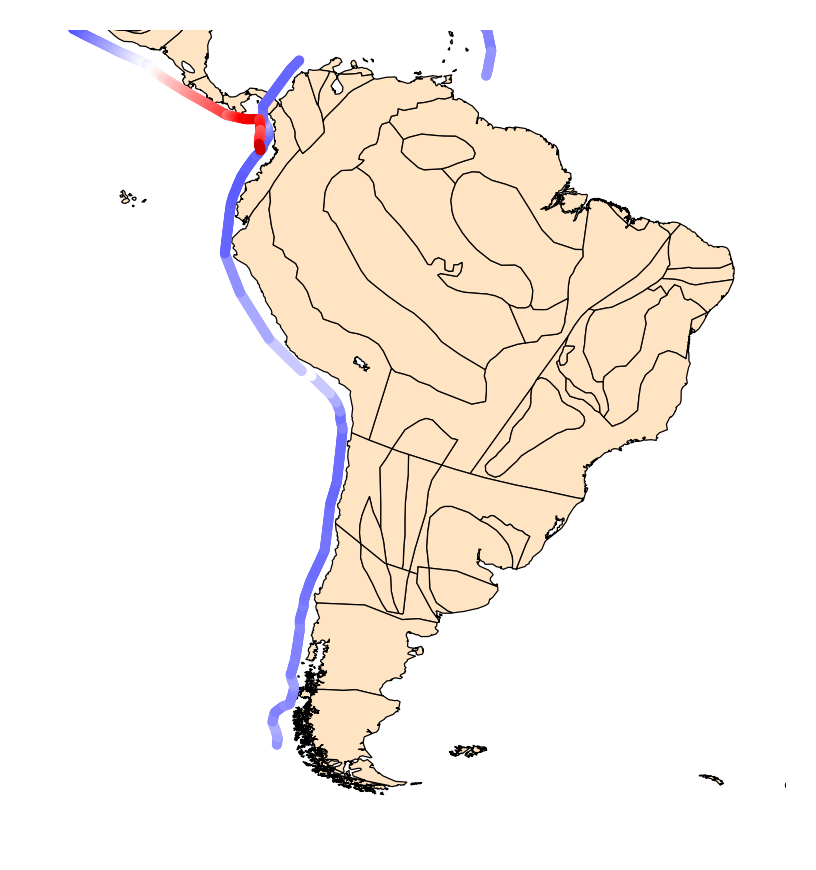

In [ ]:
time=0
coastlines_gdf=gpd.read_file(coastlines)
delta=get_cpt.get_cmap("BlueDarkRed18.cpt")
fig,ax=plt.subplots(1,1,figsize=[3,3],dpi=300)
df=PK.get_subductiondf(time)
coastlines_gdf.plot(ax=ax,facecolor='bisque',edgecolor='k',lw=0.3,alpha=1.0)
df.plot(ax=ax,column='Migration Rate',cmap='seismic',markersize=2,legend=False,vmax=0.03,vmin=-0.03)
plt.xlim([-100,-30])
plt.ylim([-60,15])
plt.axis('off')
plt.tight_layout()


In [ ]:
# plt.scatter(TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Trench Distance'])

 # Calculated Mean Subduction Parameters 
The unprocessed file with be save it as .parquet file. This will take a lot of time when run at high resolution

In [ ]:
# training_df=PK.create_points_around_trench(all_subduction_df=all_sz_df,reconstruction_time=reconstruction_time,
#                                 tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
#                                 mesh_refinement_level=MESH_REFINEMENT_LEVEL)




In [ ]:
# for rt in range(0,15):
#     rlons, rlats, indices =gpts.reconstruct(rt,return_array=True,return_point_indices=True)
#     # Step 1: Build a DataFrame
#     df = pd.DataFrame({
#         "Longitude": rlons,
#         "Latitude": rlats,
#         "Index": indices
#     })

#     # Step 2: Convert to GeoDataFrame
#     margin_gdf = gpd.GeoDataFrame(
#         df.set_index("Index"),  # drop=True by default,
#         geometry=[Point(xy) for xy in zip(df["Longitude"], df["Latitude"])],
#         crs=DEFAULT_CRS # WGS84 Lat/Lon
#     )

#     reconstructed_subduction = all_sz_df[all_sz_df['Time']==rt].copy()
#     reconstructed_subduction_gdf=gpd.GeoDataFrame(reconstructed_subduction,geometry=gpd.points_from_xy(reconstructed_subduction['Trench Longitude'],reconstructed_subduction['Trench Latitude']))
#     reconstructed_subduction_gdf=reconstructed_subduction_gdf.set_crs(DEFAULT_CRS)

#     combined_df = sjoin_nearest_geodesic_points(margin_gdf, reconstructed_subduction_gdf, distance_col='Trench Distance')
#     combined_df=combined_df.to_crs(DEFAULT_CRS)
#     print(f"Combining Data as a dataframe for Time={rt} Ma")
#     # combined_df.to_parquet(f"{training_data}/combined_df_{rt}.csv")
#     break
    

    

    

In [ ]:

# def get_plate_kinematics_gplately(training_df,
#                                     all_sz_df,
#                                     reconstruction_time=int(reconstruction_time),
#                                     window_size=int(WINDOW_SIZE),
#                                     weighted_mean=Weighted,
#                                     timesteps=TIME_STEPS,
#                                     exclude_cols = ["Latitude", "Longitude", "Trench Distance"]):
    
    
#     gpts=PK.get_gpts_from_df(training_df)

#     all_results = []

#     for rt in range(reconstruction_time,reconstruction_time+window_size+1,timesteps):
#         # reconstruct margin points
#         rlons, rlats, indices = gpts.reconstruct(
#             rt, return_array=True, return_point_indices=True
#         )
        
#         margin_df = pd.DataFrame({
#             "Longitude": rlons,
#             "Latitude": rlats,
#             "Index": indices
#         })
        
#         margin_gdf = gpd.GeoDataFrame(margin_df,
#                                     geometry=gpd.points_from_xy(margin_df['Longitude'],margin_df['Latitude'],crs=DEFAULT_CRS))

#         # reconstruct subduction
#         reconstructed_subduction = all_sz_df[all_sz_df['Time'] == rt].copy()
#         reconstructed_subduction_gdf = gpd.GeoDataFrame(
#             reconstructed_subduction,
#             geometry=gpd.points_from_xy(
#                 reconstructed_subduction['Trench Longitude'],
#                 reconstructed_subduction['Trench Latitude']
#             ),
#             crs=DEFAULT_CRS
#         )

#         # nearest-join margin and subduction
#         subduction_df = sjoin_nearest_geodesic_points(
#             margin_gdf, reconstructed_subduction_gdf, distance_col="Trench Distance"
#         )
        
#         # keep a copy (with Index preserved)
#         all_results.append(subduction_df)

#         print(f"Combining Data as a dataframe for Time={rt} Ma")


    
    
#     if weighted_mean:
#         mean_df = calculate_wma(all_results)
#     else:
#         sum_df = sum(all_results)
#         mean_df=sum_df/ len(all_results)
#     for col in exclude_cols:
#         mean_df[col]=all_results[0][col]
    
#     return mean_df




In [ ]:
## this is test run so we try to run just upto 10 Ma 

create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma")

for reconstruction_time in range(TO_TIME,FROM_TIME+1,TIME_STEPS):

    # if reconstruction_time==100:  # comment this and next line if you want to run to full time step
    #     break
  

    print(f"Working on time={reconstruction_time} Ma")
    training_df=PK.create_points_around_trench(all_subduction_df=all_sz_df,reconstruction_time=reconstruction_time,
                                   tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
                                   mesh_refinement_level=MESH_REFINEMENT_LEVEL)
    TrainingData=PK.get_plate_kinematics_gplately(training_df,
                                         all_sz_df,
                                         reconstruction_time=int(reconstruction_time),
                                         window_size=int(WINDOW_SIZE),
                                         weighted_mean=Weighted,
                                         timesteps=TIME_STEPS,
                                         exclude_cols=['Trench Longitude','Trench Latitude', 'Longitude', 'Trench Distance'])
    
    TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/Data_{reconstruction_time}.parquet")
   
    print("Done!")
    # break


Created directory: /Volumes/SatyamData/Merdith1Ga/1Ga_Reconstructions/Paleotopography/CSV/Window_Size_15_Ma
Working on time=0 Ma


KeyboardInterrupt: 

In [ ]:
from joblib import Parallel, delayed
import os

def process_reconstruction_time(reconstruction_time):
    print(f"Working on time={reconstruction_time} Ma")

    training_df = PK.create_points_around_trench(
        all_subduction_df=all_sz_df,
        reconstruction_time=reconstruction_time,
        tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
        mesh_refinement_level=MESH_REFINEMENT_LEVEL
    )

    TrainingData = PK.get_plate_kinematics_gplately(
        training_df,
        all_sz_df,
        reconstruction_time=int(reconstruction_time),
        window_size=int(WINDOW_SIZE),
        weighted_mean=Weighted,
        timesteps=TIME_STEPS,
        exclude_cols=['Trench Longitude','Trench Latitude','Longitude','Latitude']
    )

    outdir = f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma"
    os.makedirs(outdir, exist_ok=True)
    TrainingData.to_parquet(f"{outdir}/Data_{reconstruction_time}.parquet")

    print(f"Done with {reconstruction_time} Ma")
    return reconstruction_time


# --- Parallel execution ---
times = range(TO_TIME+393, FROM_TIME + 1, TIME_STEPS)

results = Parallel(n_jobs=8)(  # -1 means use all CPUs
    delayed(process_reconstruction_time)(t) for t in times
)


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on time=393 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on time=394 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on time=395 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on time=396 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on time=397 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on time=398 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Working on time=399 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Working on time=400 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=394 Ma
Combining Data as a dataframe for Time=395 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=396 Ma
Combining Data as a dataframe for Time=393 Ma
Combining Data as a dataframe for Time=397 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=398 Ma
Combining Data as a dataframe for Time=394 Ma
Combining Data as a dataframe for Time=396 Ma
Combining Data as a dataframe for Time=399 Ma
Combining Data as a dataframe for Time=395 Ma
Combining Data as a dataframe for Time=397 Ma
Combining Data as a dataframe for Time=400 Ma
Combining Data as a dataframe for Time=398 Ma
Combining Data as a dataframe for Time=401 Ma
Combining Data as a dataframe for Time=396 Ma
Combining Data as a dataframe for Time=395 Ma
Combining Data as a dataframe for Time=399 Ma
Combining Data as a dataframe for Time=402 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=397 Ma
Combining Data as a dataframe for Time=396 Ma
Combining Data as a dataframe for Time=400 Ma
Combining Data as a dataframe for Time=398 Ma
Combining Data as a dataframe for Time=403 Ma
Combining Data as a dataframe for Time=401 Ma
Combining Data as a dataframe for Time=398 Ma
Combining Data as a dataframe for Time=399 Ma
Combining Data as a dataframe for Time=397 Ma
Combining Data as a dataframe for Time=404 Ma
Combining Data as a dataframe for Time=402 Ma
Combining Data as a dataframe for Time=400 Ma
Combining Data as a dataframe for Time=405 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=399 Ma
Combining Data as a dataframe for Time=398 Ma
Combining Data as a dataframe for Time=403 Ma
Combining Data as a dataframe for Time=397 Ma
Combining Data as a dataframe for Time=401 Ma
Combining Data as a dataframe for Time=406 Ma
Combining Data as a dataframe for Time=400 Ma
Combining Data as a dataframe for Time=404 Ma
Combining Data as a dataframe for Time=399 Ma
Combining Data as a dataframe for Time=402 Ma
Combining Data as a dataframe for Time=398 Ma
Combining Data as a dataframe for Time=407 Ma
Combining Data as a dataframe for Time=403 Ma
Combining Data as a dataframe for Time=405 Ma
Combining Data as a dataframe for Time=401 Ma
Combining Data as a dataframe for Time=400 Ma
Combining Data as a dataframe for Time=399 Ma
Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=406 Ma
Combining Data as a dataframe for Time=404 Ma
Combining Data as a dataframe for Time=402 Ma
Combining Data as a dataframe for 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=409 Ma
Working on time=404 Ma
Done with 395 Ma
Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=411 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=412 Ma
Using weighted mean
Working on time=405 Ma
Combining Data as a dataframe for Time=411 Ma
Combining Data as a dataframe for Time=411 Ma
Combining Data as a dataframe for Time=412 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Done with 397 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=401 Ma
Combining Data as a dataframe for Time=413 Ma
Working on time=406 Ma
Combining Data as a dataframe for Time=414 Ma
Using weighted mean
Combining Data as a dataframe for Time=402 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=403 Ma
Done with 399 Ma
Combining Data as a dataframe for Time=415 Ma
Using weighted mean
Combining Data as a dataframe for Time=404 Ma
Combining Data as a dataframe for Time=405 Ma
Done with 400 Ma
Combining Data as a dataframe for Time=402 Ma
Combining Data as a dataframe for Time=406 Ma
Working on time=407 Ma
Combining Data as a dataframe for Time=403 Ma
Combining Data as a dataframe for Time=407 Ma
Combining Data as a dataframe for Time=404 Ma
Working on time=408 Ma
Combining Data as a dataframe for Time=408 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=405 Ma
Combining Data as a dataframe for Time=403 Ma
Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=406 Ma
Combining Data as a dataframe for Time=404 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=405 Ma
Combining Data as a dataframe for Time=407 Ma
Combining Data as a dataframe for Time=411 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=406 Ma
Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=407 Ma
Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=411 Ma
Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=404 Ma
Combining Data as a dataframe for Time=416 Ma
Using weighted mean
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=405 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=411 Ma
Done with 401 Ma
Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=406 Ma
Combining Data as a dataframe for Time=405 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=416 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=407 Ma
Combining Data as a dataframe for Time=406 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=417 Ma
Using weighted mean
Working on time=409 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=407 Ma
Combining Data as a dataframe for Time=417 Ma
Done with 402 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=418 Ma
Using weighted mean
Combining Data as a dataframe for Time=406 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=409 Ma
Working on time=410 Ma
Done with 403 Ma
Combining Data as a dataframe for Time=407 Ma
Combining Data as a dataframe for Time=411 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=411 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=412 Ma
Working on time=411 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=407 Ma
Combining Data as a dataframe for Time=411 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=408 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=417 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=411 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=410 Ma
Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=419 Ma
Using weighted mean
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=411 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=419 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=414 Ma
Done with 404 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=420 Ma
Using weighted mean
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=414 Ma
Working on time=412 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=410 Ma
Done with 405 Ma
Combining Data as a dataframe for Time=419 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=411 Ma
Combining Data as a dataframe for Time=409 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=420 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=416 Ma
Working on time=413 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=410 Ma
Combining Data as a datafr

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=419 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=422 Ma
Combining Data as a dataframe for Time=420 Ma
Done with 408 Ma
Combining Data as a dataframe for Time=417 Ma
Done with 407 Ma
Combining Data as a dataframe for Time=423 Ma
Combining Data as a dataframe for Time=421 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=424 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=422 Ma
Working on time=415 Ma
Combining Data as a dataframe for Time=425 Ma
Using weighted mean
Combining Data as a dataframe for Time=423 Ma
Combining Data as a dataframe for Time=419 Ma
Combining Data as a dataframe for Time=424 Ma
Working on time=416 Ma
Combining Data as a dataframe for Time=420 Ma
Done with 410 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=412 Ma
Combining Data as a dataframe for Time=421 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=426 Ma
Using weighted mean
Combining Data as a dataframe for Time=413 Ma
Combining Data as a dataframe for Time=422 Ma
Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=413 Ma
Working on time=417 Ma
Combining Data as a dataframe for Time=423 Ma
Done with 411 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=414 Ma
Combining Data as a dataframe for Time=424 Ma
Using weighted mean
Working on time=418 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=416 Ma
Done with 409 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=414 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=419 Ma
Working on time=419 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=415 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=420 Ma
Combining Data as a dataframe for Time=419 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=420 Ma
Combining Data as a dataframe for Time=421 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=421 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=422 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=419 Ma
Combining Data as a dataframe for Time=422 Ma
Combining Data as a dataframe for Time=423 Ma
Combining Data as a dataframe for Time=415 Ma
Combining Data as a dataframe for Time=420 Ma
Combining Data as a dataframe for Time=423 Ma
Combining Data as a dataframe for Time=424 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=416 Ma
Combining Data as a dataframe for Time=421 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=424 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=422 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=423 Ma
Combining Data as a dataframe for Time=419 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=419 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=426 Ma
Combining Data as a dataframe for Time=420 Ma
Combining Data as a dataframe for Time=420 Ma
Combining Data as a dataframe for Time=424 Ma
Combining Data as a dataframe for Time=419 Ma
Combining Data as a dataframe for Time=426 Ma
Combining Data as a dataframe for Time=417 Ma
Combining Data as a dataframe for Time=427 Ma
Using weighted mean
Combining Data as a dataframe for Time=420 Ma
Combining Data as a dataframe for Time=421 Ma
Combining Data as a dataframe for Time=421 Ma
Combining Data as a dataframe for Time=418 Ma
Combining Data as a dataframe for Time=421 Ma
Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=422 Ma
Combining Data as a dataframe for Time=419 Ma
Combining Data as a dataframe for Time=422 Ma
Combining Data as a dataframe for Time=422 Ma
Done with 412 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=430 Ma
Using weighted mean
Combining Data as a dataframe for Time=428 Ma
Done with 418 Ma
Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=429 Ma
Combining Data as a dataframe for Time=431 Ma
Using weighted mean
Done with 415 Ma
Combining Data as a dataframe for Time=428 Ma
Working on time=423 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=429 Ma
Done with 416 Ma
Working on time=424 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=420 Ma
Working on time=425 Ma
Combining Data as a dataframe for Time=421 Ma
Combining Data as a dataframe for Time=432 Ma
Using weighted mean
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=421 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=422 Ma
Combining Data as a dataframe for Time=422 Ma
Done with 417 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=423 Ma
Combining Data as a dataframe for Time=423 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=424 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=424 Ma
Working on time=426 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=426 Ma
Combining Data as a dataframe for Time=434 Ma
Using weighted mean
Combining Data as a dataframe for Time=422 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=423 Ma
Combining Data as a dataframe for Time=423 Ma
Combining Data as a dataframe for Time=424 Ma
Combining Data as a dataframe for Time=428 Ma
Done with 419 Ma
Combining Data as a dataframe for Time=426 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=424 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=429 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=426 Ma
Working on time=427 Ma
Combining Data as a dataframe for Time=426 Ma
Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=428 Ma
Combining Data as a dataframe for Time=428 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=429 Ma
Combining Data as a dataframe for Time=428 Ma
Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=429 Ma
Combining Data as a dataframe for Time=424 Ma
Combining Data as a dataframe for Time=429 Ma
Combining Data as a dataframe for Time=431 Ma
Combining D

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=426 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=428 Ma
Combining Data as a dataframe for Time=436 Ma
Using weighted mean
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=429 Ma
Combining Data

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=425 Ma
Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=433 Ma
Done with 423 Ma
Combining Data as a dataframe for Time=426 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=431 Ma
Working on time=428 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=428 Ma
Working on time=429 Ma
Combining Data as a dataframe for Time=437 Ma
Using weighted mean
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=429 Ma
Combining Data as a dataframe for Time=435 Ma
Using weighted mean
Combining Data as a dataframe for Time=426 Ma
Combining Data as a dataframe for Time=434 Ma
Done with 422 Ma
Combining Data as a dataframe for Time=430 Ma
Combining Data as a dataframe for Time=427 Ma
Done with 420 Ma
Combining Data as a dataframe for Time=427 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=428 Ma
Working on time=430 Ma
Combining Data as a dataframe for Time=428 Ma
Combining Data as a dataframe for Time=436 Ma
Combin

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=434 Ma
Working on time=432 Ma
Combining Data as a dataframe for Time=438 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=439 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=440 Ma
Using weighted mean
Combining Data as a dataframe for Time=429 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=430 Ma
Done with 425 Ma
Combining Data as a dataframe for Time=438 Ma
Combining Data as a dataframe for Time=438 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=439 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=439 Ma
Working on time=433 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=440 Ma
Combining Data as a dataframe for Time=428 Ma
Combining Data as a dataframe for Time=440 Ma
Combining Data as a dataframe for Time=434 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=441 Ma
Using weighted mean
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=429 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=430 Ma
Done with 426 Ma
Combining Data as a dataframe for Time=442 Ma
Using weighted mean
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=438 Ma
Done with 427 Ma
Combining Data as a dataframe for Time=439 Ma
Working on time=434 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=440 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=430 Ma
Working on time=435 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=442 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=431 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=444 Ma
Using weighted mean
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=436 Ma
Done with 429 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=434 Ma
Working on time=436 Ma
Combining Data as a dataframe for Time=438 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=432 Ma
Combining Data as a dataframe for Time=439 Ma
Combining Data as a dataframe for Time=436 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=440 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=438 Ma
Combining Data as a dataframe for Time=438 Ma
Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=439 Ma
Combining Data as a dataframe for Time=439 Ma
Combining Data as a dataframe for Time=443 Ma
Using weighted mean
Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=440 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=440 Ma
Done with 428 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=433 Ma
Combining Data as a dataframe for Time=438 Ma
Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=434 Ma
Working on time=437 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=439 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=440 Ma
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=434 Ma
Combining Data as a dataframe for Time=445 Ma
Using weighted mean
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=435 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dataframe for Time=442 Ma
Done with 430 Ma
Combining Data as a dataframe for Time=446 Ma
Using weighted mean
Combining Data as a dataframe for Time=436 Ma
Combining Data as a dataframe for Time=438 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=437 Ma
Combining Data as a dat

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=448 Ma
Using weighted mean
Combining Data as a dataframe for Time=450 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=451 Ma
Using weighted mean
Done with 433 Ma
Combining Data as a dataframe for Time=449 Ma
Using weighted mean
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=437 Ma
Done with 436 Ma
Combining Data as a dataframe for Time=438 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Working on time=441 Ma
Combining Data as a dataframe for Time=447 Ma
Done with 434 Ma
Combining Data as a dataframe for Time=439 Ma
Combining Data as a dataframe for Time=448 Ma
Working on time=442 Ma
Combining Data as a dataframe for Time=440 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=438 Ma
Working on time=443 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=450 Ma
Using weighted mean
Combining Data as a dataframe for Time=439 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=442 Ma
Done with 435 Ma
Combining Data as a dataframe for Time=439 Ma
Combining Data as a dataframe for Time=440 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=440 Ma
Working on time=444 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=443 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=440 Ma
Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=445 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=451 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=441 Ma
Combining Data as a dataframe for Time=452 Ma
Using weighted mean
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=442 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=447 Ma
Done with 437 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=451 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=444 Ma
Working on time=445 Ma
Combining Data as a dataframe for Time=451 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=443 Ma
Combining Data as a dataframe for Time=451 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=453 Ma
Using weighted mean
Combining Data as a dataframe for Time=444 Ma
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=445 Ma
Combining Data as a dataframe for Time=454 Ma
Combining Data as a dataframe for Tim

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=451 Ma
Working on time=449 Ma
Combining Data as a dataframe for Time=454 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=456 Ma
Using weighted mean
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=453 Ma
Done with 441 Ma
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=454 Ma
Working on time=450 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=445 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=458 Ma
Using weighted mean
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=446 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Done with 443 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=458 Ma
Working on time=451 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=459 Ma
Using weighted mean
Combining Data as a dataframe for Time=446 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=447 Ma
Done with 444 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=451 Ma
Combining Data as a dataframe for Time=447 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=448 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=451 Ma
Combining Data as a dataframe for Time=448 Ma
Working on time=452 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=454 Ma
Combining Data as a dataframe for Time=454 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=451 Ma
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=451 Ma
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=457 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=449 Ma
Combining Data as a dataframe for Time=454 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=454 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=451 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=463 Ma
Using weighted mean
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=450 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=460 Ma
Using weighted mean
Combining Data as a dataframe for Time=457 Ma
Done with 448 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=451 Ma
Combining Data as a dataframe for Time=454 Ma
Combining Data as a dataframe for Time=458 Ma
Done with 445 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=455 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Working on time=453 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=454 Ma
Working on time=454 Ma
Combining Data as a dataframe for Time=451 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=461 Ma
Using weighted mean
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=452 Ma
Combining Data as a dataframe for Time=458 Ma
Done with 446 Ma
Combining Data as a dataframe for Time=462 Ma
Using weighted mean
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=459 Ma
Done with 447 Ma
Combining Data as a dataframe for Time=457 Ma
Working on time=455 Ma
Combining Data as a dataframe

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=464 Ma
Using weighted mean
Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=456 Ma
Done with 449 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=464 Ma
Working on time=457 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=453 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=465 Ma
Using weighted mean
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=454 Ma
Done with 450 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=461 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=462 Ma
Working on time=458 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=454 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=455 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=455 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=466 Ma
Using weighted mean
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=465 Ma
Done with 451 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=459 Ma
Working on time=459 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=467 Ma
Using weighted mean
Combining Data as a dataframe for Time=456 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=468 Ma
Using weighted mean
Combining Data as a dataframe for Time=459 Ma
Done with 452 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=461 Ma
Done with 453 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=458 Ma
Working on time=460 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=459 Ma
Working on time=461 Ma
Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=457 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=458 Ma
Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=467 Ma
Combining D

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=468 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=469 Ma
Using weighted mean


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=468 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=462 Ma
Done with 454 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=469 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=470 Ma
Using weighted mean
Working on time=462 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=459 Ma
Combining Data as a dataframe for Time=468 Ma
Done with 455 Ma
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=460 Ma
Combining Data as a dataframe for Time=469 Ma
Working on time=463 Ma
Combining Data as a dataframe for Time=462 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=461 Ma
Combining Data as a dataframe for Time=463 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=472 Ma
Using weighted mean
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=471 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=466 Ma
Done with 457 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=468 Ma
Combining Data as a dataframe for Time=473 Ma
Using weighted mean
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=474 Ma
Working on time=465 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=469 Ma
Combining Data as a dataframe for Time=475 Ma
Done with 458 Ma
Combining Data as a dataframe for Time=468 Ma
Combining Data as a dataframe for Time=476 Ma
Using weighted mean
Combining Data as a dataframe for Time=470 Ma
Combining Data as a dataframe for Time=462 Ma
Working on time=466 Ma
Combining Data as a dataframe for Time=469 Ma
Done with 461 Ma
Combining Data as a dataframe for Time=471 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=470 Ma
Working on time=467 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=472 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=471 Ma
Combining Data as a dataframe for Time=463 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=474 Ma
Using weighted mean
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=467 Ma
Done with 459 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=468 Ma
Working on time=468 Ma
Combining Data as a dataframe for Time=464 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=475 Ma
Using weighted mean


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=469 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=468 Ma
Done with 460 Ma
Combining Data as a dataframe for Time=470 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=469 Ma
Working on time=469 Ma
Combining Data as a dataframe for Time=471 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=470 Ma
Combining Data as a dataframe for Time=468 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=471 Ma
Combining Data as a dataframe for Time=465 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=469 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=468 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=466 Ma
Combining Data as a dataframe for Time=469 Ma
Combining Data as a dataframe for Time=470 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=467 Ma
Combining Data as a dataframe for Time=470 Ma
Combining D

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=469 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=475 Ma
Combining Data as a dataframe for Time=469 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=477 Ma
Using weighted mean
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=470 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=470 Ma
Combining Data as a dataframe for Time=475 Ma
Combining Data as a dataframe for Time=474 Ma
Done with 462 Ma
Combining Data as a dataframe for Time=471 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=471 Ma
Combining Data as a dataframe for Time=475 Ma
Combining Data as a dataframe for Time=477 Ma
Working on time=470 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=478 Ma
Using weighted mean
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=468 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=479 Ma
Done with 463 Ma
Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=469 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=481 Ma
Working on time=471 Ma
Combining Data as a dataframe for Time=478 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=479 Ma
Working on time=473 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=479 Ma
Combining Data as a dataframe for Time=480 Ma
Using weighted mean


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=475 Ma
Combining Data as a dataframe for Time=480 Ma
Done with 465 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=481 Ma
Using weighted mean
Combining Data as a dataframe for Time=475 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=477 Ma
Working on time=474 Ma
Combining Data as a dataframe for Time=476 Ma
Done with 466 Ma
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=477 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Working on time=475 Ma
Combining Data as a dataframe for Time=479 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=470 Ma
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=471 Ma
Combining Data as a dataframe for Time=479 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=481 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=473 Ma
Combining Data as a dataframe for Time=483 Ma
Using weighted mean
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=473 Ma
Done with 468 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=471 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=475 Ma
Working on time=476 Ma
Combining Data as a dataframe for Time=484 Ma
Using weighted mean
Combining Data as a dataframe for Time=475 Ma
Combining Data as a dataframe for Time=472 Ma
Combining Data as a dataframe for Time=476 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Done with 469 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=473 Ma
Working on time=477 Ma
Combining Data as a dataframe for Time=473 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=479 Ma
Combining Data as a dataframe for Time=479 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=475 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=475 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=474 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=475 Ma
Combining Data as a dataframe for 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=479 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=487 Ma
Using weighted mean
Combining Data as a dataframe for Time=485 Ma
Using weighted mean
Combining Data as a dataframe for Time=479 Ma
Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=480 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Done with 470 Ma
Done with 472 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=478 Ma
Combining Data as a dataframe for Time=481 Ma
Working on time=478 Ma
Combining Data as a dataframe for Time=479 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=479 Ma
Working on time=479 Ma
Combining Data as a dataframe for Time=476 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=477 Ma
Combining Data as a dataframe for Time=478 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=485 Ma
Working on time=480 Ma
Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=482 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=488 Ma
Using weighted mean
Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=487 Ma
Done with 473 Ma
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=488 Ma
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=488 Ma
Working on time=481 Ma
Combining Data as a dataframe for Time=479 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=489 Ma
Using weighted mean
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=481 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Done with 475 Ma
Combining Data as a dataframe for Time=480 Ma
Combining Data as a dataframe for Time=488 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=489 Ma
Working on time=483 Ma
Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=488 Ma
Combining Data as a dataframe for Time=491 Ma
Using weighted mean
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=491 Ma
Done with 476 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=492 Ma
Using weighted mean
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Working on time=484 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=485 Ma
Done with 477 Ma
Combining Data as a dataframe for Time=481 Ma
Combining Data as a dataframe for Time=493 Ma
Working on time=485 Ma
Combining Data as a dataframe for Time=486 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=494 Ma
Using weighted mean
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=483 Ma
Done with 479 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=481 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=488 Ma
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=482 Ma
Working on time=486 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=482 Ma
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=491 Ma
Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=483 Ma
Combining Data as a dataframe for Time=484 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=488 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=493 Ma
Using weighted mean
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=488 Ma
Combining Data as a dataframe for Time=489 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=486 Ma
Done with 478 Ma
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=488 Ma
Working on time=487 Ma
Combining Data as a dataframe for Time=484 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=491 Ma
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=488 Ma
Combining Data as a dataframe for Time=491 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=485 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=486 Ma
Combining Data as a dataframe for Time=493 Ma
Combining Data as a dataframe for Time=4

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=491 Ma
Combining Data as a dataframe for Time=495 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=492 Ma
Done with 482 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=493 Ma
Working on time=489 Ma
Combining Data as a dataframe for Time=497 Ma
Combining Data as a dataframe for Time=497 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=493 Ma
Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe for Time=494 Ma
Combining Data as a dataframe for Time=498 Ma
Using weighted mean
Combining Data as a dataframe for Time=499 Ma
Combining Data as a dataframe for Time=494 Ma
Working on time=490 Ma
Combining Data as a dataframe for Time=495 Ma
Combining Data as a dataframe for Time=500 Ma
Done with 483 Ma
Combining Data as a dataframe for Time=495 Ma
Combining Data as a dataframe for Time=501 Ma
Using weighted mean
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=487 Ma
Combining Data as a dataframe for Time=497 Ma
Done with 486 Ma
Working on time=491 Ma
Combining Data as a dataframe for Time=497 Ma
Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe for Time=488 Ma
Working on time=492 Ma
Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=500 Ma
Using weighted mean
Combining Data as a dataframe for Time=490 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=491 Ma
Done with 485 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=492 Ma
Working on time=493 Ma
Combining Data as a dataframe for Time=493 Ma
Working on time=494 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=494 Ma
Combining Data as a dataframe for Time=495 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=488 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=491 Ma
Combining Data as a dataframe for Time=497 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=489 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=493 Ma
Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe for Time=494 Ma
Combining Data as a dataframe for Time=491 Ma
Combining Data as a dataframe for Time=490 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=499 Ma
Combining Data as a dataframe for Time=495 Ma
Combining Data as a dataframe for Time=493 Ma
Combining Data as a dataframe for Time=491 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe for Time=492 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=499 Ma
Combining Data as a dataframe for Time=502 Ma
Using weighted mean
Combining Data as a dataframe for Time=494 Ma
Combining Data as a dataframe for Time=493 Ma
Combining Data as a dataframe for Time=497 Ma
Combining Data as a dataframe for Time=500 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=493 Ma
Combining Data as a dataframe for Time=495 Ma
Combining Data as a dataframe for Time=494 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=498 Ma
Done with 487 Ma
Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=499 Ma
Combining Data as a dataframe for Time=494 Ma
Combining Data as a dataframe for Time=495 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=503 Ma
Combining Data as a dataframe for Time=500 Ma
Working on time=495 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=495 Ma
Combining Data as a dataframe for Time=497 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=505 Ma
Using weighted mean
Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=498 Ma
Combining Data as a 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=501 Ma
Working on time=499 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=506 Ma
Using weighted mean
Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=503 Ma
Combining Data as a dataframe for Time=503 Ma
Done with 491 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=504 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Working on time=500 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=495 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=496 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=497 Ma
Combining Data as a dataframe for Time=508 Ma
Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe for Time=497 Ma
Combining Data as a dataframe for Time=508 Ma
Using weighted mean
Combining Data as a dataframe for Time=499 Ma
Combining Data as a dataframe for Time=509 Ma
Using weighted mean


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=497 Ma
Done with 493 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe for Time=499 Ma
Done with 494 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=499 Ma
Working on time=501 Ma
Combining Data as a dataframe for Time=503 Ma
Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=502 Ma
Working on time=502 Ma
Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=503 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=503 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=498 Ma
Combining Data as a dataframe for Time=508 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=499 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=499 Ma
Combining Data as a dataframe for Time=508 Ma
Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=511 Ma
Using weighted mean
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=507 Ma
Done with 496 Ma
Combining Data as a dataframe for Time=501 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=503 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=504 Ma
Working on time=503 Ma
Done with 497 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=510 Ma
Using weighted mean
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=505 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=505 Ma
Working on time=504 Ma
Combining Data as a dataframe for Time=506 Ma
Done with 495 Ma
Combining Data as a dataframe for Time=503 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=508 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=508 Ma
Combining Data as a dataframe for Time=509 Ma
Working on time=505 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=501 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=508 Ma
Combining Data as a dataframe for Time=502 Ma
Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for Time=503 Ma
Combining Data as a dataframe for Time=509 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=503 Ma
Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=513 Ma
Using weighted mean
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=504 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=513 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=511 Ma
Done with 498 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=514 Ma
Using weighted mean
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=507 Ma
Working on time=506 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=513 Ma
Done with 499 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=508 Ma
Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=508 Ma
Working on time=507 Ma
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=515 Ma
Using weighted mean
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=503 Ma
Done with 500 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=504 Ma
Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=508 Ma
Combining Data as a dataframe for Time=512 Ma
Com

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=516 Ma
Using weighted mean
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=513 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=517 Ma
Done with 501 Ma
Combining Data as a dataframe for Time=517 Ma
Using weighted mean
Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for Time=519 Ma
Using weighted mean
Done with 502 Ma
Working on time=509 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=513 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=514 Ma
Working on time=510 Ma
Done with 504 Ma
Combining Data as a dataframe for Time=506 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=507 Ma
Combining Data as a dataframe for Time=520 Ma
Using weighted mean
Combining Data as a dataframe for Time=507 Ma
Working on time=511 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=508 Ma
Combining Data as a dataframe for Time=508 Ma
Done with 505 Ma
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=518 Ma
Using weighted mean
Working on time=512 Ma
Combining Data as a dataframe

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=513 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=513 Ma
Working on time=513 Ma
Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=514 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=513 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=516 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for Time=509 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=513 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=511 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=512 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=521 Ma
Using weighted mean
Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=513 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=513 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=522 Ma
Using weighted mean
Combining Data as a dataframe for Time=514 Ma
Done with 506 Ma
Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=515 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dat

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=522 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=523 Ma
Using weighted mean
Working on time=515 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=515 Ma
Done with 511 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=525 Ma
Done with 508 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=519 Ma
Working on time=516 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=527 Ma
Using weighted mean
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=518 Ma
Done w

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=521 Ma
Working on time=517 Ma
Combining Data as a dataframe for Time=522 Ma
Working on time=518 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=522 Ma
Combining Data as a dataframe for Time=523 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=524 Ma
Using weighted mean
Combining Data as a dataframe for Time=522 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=523 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=525 Ma
Using weighted mean
Done with 509 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=525 Ma
Done with 510 Ma
Working on time=519 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=514 Ma
Combining Data as a dataframe for Time=527 Ma
Combining Data as a dataframe for Time=515 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Combining Data as a dataframe for Time=528 Ma
Using weighted mean


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=516 Ma
Working on time=520 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=515 Ma
Done with 513 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=516 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=519 Ma
Working on time=521 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=517 Ma
Combining Data as a dataframe for Time=519 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=522 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=525 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=522 Ma
Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=522 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=527 Ma
Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=518 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=531 Ma
Using weighted mean
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=527 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=528 Ma
Combining Data as a dataframe for Time=527 Ma
Done with 516 Ma
Combining Data as a dataframe for Time=525 Ma
Combining Data as a dataframe for Time=529 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=528 Ma
Combining Data as a dataframe for Time=526 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=530 Ma
Combining Data as a dataframe for Time=529 Ma
Using weighted mean
Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=531 Ma
Working on time=522 Ma
Combining Data as a dataframe for Time=527 Ma
Combining Data as a dataframe for Time=532 Ma
Combining Data as a dataframe for Time=522 Ma
Combining Data as a dataframe for Time=528 Ma
Combining Data as a dataframe for Time=533 Ma
Using weighted mean
Done with 514 Ma
Combining Data as a dataframe for Time=519 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=529 Ma
Combining Data as a dataframe for Time=520 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=530 Ma
Using weighted mean
Done with 518 Ma
Working on time=523 Ma
Combining Data as a dataframe for Time=521 Ma
Combining Data as a dataframe for Time=525 Ma
Done with 515 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=529 Ma
Combining Data as a dataframe for Time=525 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=530 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=531 Ma
Combining Data as a dataframe for Time=525 Ma
Combining Data as a dataframe for Time=527 Ma
Combining Data as a dataframe for Time=525 Ma
Combining Data as a dataframe for Time=528 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=532 Ma
Using weighted mean
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=529 Ma
Combining Data as a dataframe for Time=527 Ma
Combining Data as a dataframe for Time=527 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Done with 517 Ma
Combining Data as a dataframe for Time=530 Ma
Combining Data as a dataframe for Time=528 Ma
Combining Data as a dataframe for Time=528 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=522 Ma
Combining Data as a dataframe for Time=531 Ma
Combining Data as a dataframe for Time=529 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=529 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=532 Ma
Combining Data as a dataframe for Time=530 Ma
Combining Data as a dataframe for Time=530 Ma
Combining Data as a dataframe for Time=525 Ma
Combining Data as a dataframe for Time=533 Ma
Combining Data as a dataframe for Time=531 Ma
Combining Data as a dataframe for Time=531 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=527 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=534 Ma
Using weighted mean
Combining Data as a dataframe for Time=532 Ma
Combining Data as a dataframe for Time=532 Ma
Combining Data as a dataframe for Time=528 Ma
Combining Data as a dataframe for Time=529 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=533 Ma
Combining Data as a dataframe for Time=533 Ma
Done with 519 Ma
Combining Data as a dataframe for Time=530 Ma
Combining Data as a dataframe for Time=525 Ma
Combining Data as a dataframe for Time=523 Ma
Combining Data as a dataframe for Time=534 Ma
Combining Data as a dataframe for Time=531 Ma
Combining Data as a dataframe for Time=526 Ma
Combining Data as a dataframe for Time=534 Ma
Combining Data as a dataframe for Time=524 Ma
Combining Data as a dataframe for Time=532 Ma
Combining Data as a dataframe for Time=527 Ma
Combining Data as a dataframe for Time=535 Ma
Using weighted mean
Combining Data as a dataframe for Time=535 Ma
Combining Data as a dat

In [ ]:
TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/Data_{reconstruction_time}.parquet")

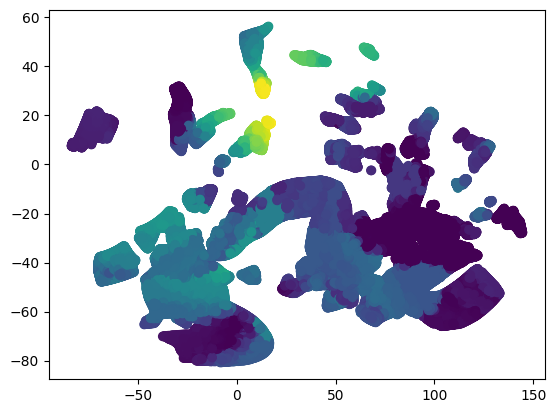

In [ ]:
plt.scatter(TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Convergence Rate'])

# Define Mantle Convection Parameters

This section of code will read all the input parameters for mantle convection model

In [ ]:
# Input Files 
MANTLE_MODEL_NAME=PARAMS['InputFiles']['mantle_convection']['model_name']
MANTLE_MODEL_DIR = PARAMS['InputFiles']['mantle_convection']['model_dir']  ## plate model
MANTLE_topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['mantle_convection']['topology_files']]
MANTLE_rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['mantle_convection']['rotation_files']]

MANTLE_depths= PARAMS['InputFiles']['mantle_convection']['depth']
MANTLE_vel_folder=PARAMS['InputFiles']['mantle_convection']['new_vel_folder']
MANTLE_temp_folder=PARAMS['InputFiles']['mantle_convection']['new_temp_folder']

MANTLE_org_vel=PARAMS['InputFiles']['mantle_convection']['original_vel_folder']
MANTLE_org_temp=PARAMS['InputFiles']['mantle_convection']['original_temp_folder']


# MANTLE_velx_folder=PARAMS['InputFiles']['mantle_convection']['new_velx_folder']
# MANTLE_org_velx=PARAMS['InputFiles']['mantle_convection']['original_velx_folder']

# MANTLE_vely_folder=PARAMS['InputFiles']['mantle_convection']['new_vely_folder']
# MANTLE_org_vely=PARAMS['InputFiles']['mantle_convection']['original_vely_folder']

# MANTLE_visc_folder=PARAMS['InputFiles']['mantle_convection']['new_visc_folder']
# MANTLE_org_visc=PARAMS['InputFiles']['mantle_convection']['original_visc_folder']

print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Mantle Convection Plate Model: {MANTLE_MODEL_NAME} \n")
print(f"Mantle Convection Plate Model Directory: {MANTLE_MODEL_DIR} \n")

print(f"Mantle Convection Velocity: {MANTLE_vel_folder} \n")
print(f"Mantle Convection Temperature: {MANTLE_temp_folder} \n")

print(f"Mantle Convection Velocity: {MANTLE_org_vel} \n")
print(f"Mantle Convection Temperature: {MANTLE_org_temp} \n")

print(f"Mantle Convection Depths: {MANTLE_depths} \n")

print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Mantle Convection Plate Model: Merdith1Ga 

Mantle Convection Plate Model Directory: /Volumes/SatyamData/Merdith1Ga/1Ga_Reconstructions 

Mantle Convection Velocity: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional 

Mantle Convection Temperature: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional 

Mantle Convection Velocity: /Volumes/SatyamData/Merdith1Ga/STLR1GaM3A/STLR1GaM3A_vz_dimensional 

Mantle Convection Temperature: /Volumes/SatyamData/Merdith1Ga/STLR1GaM3A/STLR1GaM3A_temp_dimensional 

Mantle Convection Depths: [16, 31, 47, 62, 140, 155, 171, 186, 202, 217, 233, 268, 293, 323, 357, 396, 439, 487, 540, 597, 660, 726, 798, 874, 954, 1040] 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 



In [ ]:
MT=MantleParameters(original_folder=MANTLE_org_temp,
                    new_folder=MANTLE_temp_folder,
                    parameter_type="Mantle_Temp", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)
VZ=MantleParameters(original_folder=MANTLE_org_vel,
                    new_folder=MANTLE_vel_folder,
                    parameter_type="Mantle_Velocity", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)
# VX=MantleParameters(original_folder=MANTLE_org_velx,
#                     new_folder=MANTLE_velx_folder,
#                     parameter_type="Mantle_Velocity_X", 
#                     depths=MANTLE_depths, 
#                     starttime=TO_TIME,
#                     endtime=FROM_TIME,
#                     timestep=TIME_STEPS, 
#                     anchor_plate_id=Mantle_ID)

# VY=MantleParameters(original_folder=MANTLE_org_vely,
#                     new_folder=MANTLE_vely_folder,
#                     parameter_type="Mantle_Velocity_Y", 
#                     depths=MANTLE_depths, 
#                     starttime=TO_TIME,
#                     endtime=FROM_TIME,
#                     timestep=TIME_STEPS, 
#                     anchor_plate_id=Mantle_ID)

# VISC=MantleParameters(original_folder=MANTLE_org_visc,
#                     new_folder=MANTLE_visc_folder,
#                     parameter_type="Viscocity", 
#                     depths=MANTLE_depths, 
#                     starttime=TO_TIME,
#                     endtime=FROM_TIME,
#                     timestep=TIME_STEPS, 
#                     anchor_plate_id=Mantle_ID)

Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'


### Interpolate Mantle Convection Data at each timesteps.

In case you don't have mantle parameters at uniform time step you can use a linear interpolation. Note that this will create a huge amount of data (~1.5 GB/timesteps)


In [ ]:
MT.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)
VZ.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)
# MT.new_folder
# MT.folder
# glob.glob(f"{MT.folder}/*")

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to S

Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/0
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/0
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/10
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/20
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/30
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/40
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/50
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/60
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/70
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/80
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/90
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_dimensional/100
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/temp_di

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to S

Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/0
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/10
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/20
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/30
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/40
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/50
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/60
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/70
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/80
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/90
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/100
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/110
Created directory: /Volumes/SatyamData/Merdith1Ga/CITCOMS/vz_dimensional/120
Created di

In [ ]:
VX.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Interpolation completed from 0 Ma to 6 Ma completed.
Interpolation completed from 6 Ma to 10 Ma completed.


In [ ]:
VY.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Interpolation completed from 0 Ma to 6 Ma completed.
Interpolation completed from 6 Ma to 10 Ma completed.


In [ ]:
VISC.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/1
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/2
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/3
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/4
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/5
Interpolation completed from 0 Ma to 6 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/7
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/8
Created directory: /Volumes/Satyam/Paleotopography/STLR410MaM1/visc/9
Interpolation completed from 6 Ma to 10 Ma completed.


# Define Climate Parameters
This section will create climate parameters such as time a location spent in humid belt. Unlike other Plate Kinematics and Mantle convection parameters which are calculated in mantle reference frame. The climate parameter is calculated in Paleomag Reference Frame 

In [ ]:
CM=ClimateParameters(topology_filenames, 
                             rotation_filenames,
                             static_polygons,
                             agegrid=agegrid,
                             coastlines=coastlines,
                             continents=continents,
                             anchor_plate_id=Paleomag_ID)



# Extract Mantle Convection and Climate Parameters

This section of code will first read the data generated by PlateKinematics and then sample mantle parameters at every location. It will also track the point to calculate time a location spend in Humid Belt

In [ ]:
all_times=glob.glob(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/*")
all_times=np.sort([int(time.split('_')[-1].split('.')[0]) for time in all_times])

In [ ]:
# if Weighted:
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma")

# reconstruction_time=0
for reconstruction_time in all_times:
# for reconstruction_time in range(0,525):
    try:
        
        print(f"Getting Data at time={reconstruction_time} Ma")
        TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/Data_{reconstruction_time}.parquet")
        TrainingData=MT.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting mantle temp
        TrainingData=VZ.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting vertical mantle vel
        # TrainingData=VY.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting mantle velocity in X
        # TrainingData=VX.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting mantle velocity in Y
        # TrainingData=VISC.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## viscocity
        TrainingData=CM.get_time_spent_in_humid_belt(PK.model,TrainingData,reconstruction_time=0,window_size=15,lat_band=10,use_trench=True,
                                                drop_fraction =0.8)
        
        
        TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
       
        print("Processed and saved data!")

    except Exception as e:
        print(f"Error={e}")



Getting Data at time=0 Ma
Processed and saved data!
Getting Data at time=1 Ma
Processed and saved data!
Getting Data at time=2 Ma
Processed and saved data!
Getting Data at time=3 Ma
Processed and saved data!
Getting Data at time=4 Ma
Processed and saved data!
Getting Data at time=5 Ma
Processed and saved data!
Getting Data at time=6 Ma
Processed and saved data!
Getting Data at time=7 Ma
Processed and saved data!
Getting Data at time=8 Ma
Processed and saved data!
Getting Data at time=9 Ma
Processed and saved data!
Getting Data at time=10 Ma
Processed and saved data!
Getting Data at time=11 Ma
Processed and saved data!
Getting Data at time=12 Ma
Processed and saved data!
Getting Data at time=13 Ma
Processed and saved data!
Getting Data at time=14 Ma
Processed and saved data!
Getting Data at time=15 Ma
Processed and saved data!
Getting Data at time=16 Ma
Processed and saved data!
Getting Data at time=17 Ma
Error=operands could not be broadcast together with shapes (44165,) (44164,) (4416

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=21 Ma
Processed and saved data!
Getting Data at time=22 Ma
Processed and saved data!
Getting Data at time=23 Ma
Processed and saved data!
Getting Data at time=24 Ma
Processed and saved data!
Getting Data at time=25 Ma
Processed and saved data!
Getting Data at time=26 Ma
Processed and saved data!
Getting Data at time=27 Ma
Processed and saved data!
Getting Data at time=28 Ma
Processed and saved data!
Getting Data at time=29 Ma
Processed and saved data!
Getting Data at time=30 Ma
Processed and saved data!
Getting Data at time=31 Ma
Processed and saved data!
Getting Data at time=32 Ma
Processed and saved data!
Getting Data at time=33 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=34 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=35 Ma
Processed and saved data!
Getting Data at time=36 Ma
Processed and saved data!
Getting Data at time=37 Ma
Processed and saved data!
Getting Data at time=38 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=39 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=40 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=41 Ma
Processed and saved data!
Getting Data at time=42 Ma
Processed and saved data!
Getting Data at time=43 Ma
Processed and saved data!
Getting Data at time=44 Ma
Processed and saved data!
Getting Data at time=45 Ma
Processed and saved data!
Getting Data at time=46 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=47 Ma
Processed and saved data!
Getting Data at time=48 Ma
Processed and saved data!
Getting Data at time=49 Ma
Processed and saved data!
Getting Data at time=50 Ma
Processed and saved data!
Getting Data at time=51 Ma
Processed and saved data!
Getting Data at time=52 Ma
Processed and saved data!
Getting Data at time=53 Ma
Processed and saved data!
Getting Data at time=54 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=55 Ma
Processed and saved data!
Getting Data at time=56 Ma
Processed and saved data!
Getting Data at time=57 Ma
Processed and saved data!
Getting Data at time=58 Ma
Processed and saved data!
Getting Data at time=59 Ma
Processed and saved data!
Getting Data at time=60 Ma
Processed and saved data!
Getting Data at time=61 Ma
Processed and saved data!
Getting Data at time=62 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=63 Ma
Processed and saved data!
Getting Data at time=64 Ma
Processed and saved data!
Getting Data at time=65 Ma
Processed and saved data!
Getting Data at time=66 Ma
Processed and saved data!
Getting Data at time=67 Ma
Processed and saved data!
Getting Data at time=68 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=69 Ma
Processed and saved data!
Getting Data at time=70 Ma
Processed and saved data!
Getting Data at time=71 Ma
Processed and saved data!
Getting Data at time=72 Ma
Processed and saved data!
Getting Data at time=73 Ma
Processed and saved data!
Getting Data at time=74 Ma
Processed and saved data!
Getting Data at time=75 Ma
Processed and saved data!
Getting Data at time=76 Ma
Processed and saved data!
Getting Data at time=77 Ma
Processed and saved data!
Getting Data at time=78 Ma
Processed and saved data!
Getting Data at time=79 Ma
Processed and saved data!
Getting Data at time=80 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=81 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=82 Ma
Processed and saved data!
Getting Data at time=83 Ma
Processed and saved data!
Getting Data at time=84 Ma
Processed and saved data!
Getting Data at time=85 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=86 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=87 Ma
Processed and saved data!
Getting Data at time=88 Ma
Processed and saved data!
Getting Data at time=89 Ma
Processed and saved data!
Getting Data at time=90 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=91 Ma
Processed and saved data!
Getting Data at time=92 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=93 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=94 Ma
Error=operands could not be broadcast together with shapes (36146,) (36145,) (36146,) 
Getting Data at time=95 Ma
Processed and saved data!
Getting Data at time=96 Ma
Processed and saved data!
Getting Data at time=97 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=98 Ma
Processed and saved data!
Getting Data at time=99 Ma
Processed and saved data!
Getting Data at time=100 Ma
Processed and saved data!
Getting Data at time=101 Ma
Processed and saved data!
Getting Data at time=102 Ma
Processed and saved data!
Getting Data at time=103 Ma
Error=operands could not be broadcast together with shapes (34917,) (34916,) (34917,) 
Getting Data at time=104 Ma
Processed and saved data!
Getting Data at time=105 Ma
Processed and saved data!
Getting Data at time=106 Ma
Processed and saved data!
Getting Data at time=107 Ma
Processed and saved data!
Getting Data at time=108 Ma
Processed and saved data!
Getting Data at time=109 Ma
Processed and saved data!
Getting Data at time=110 Ma
Processed and saved data!
Getting Data at time=111 Ma
Processed and saved data!
Getting Data at time=112 Ma
Processed and saved data!
Getting Data at time=113 Ma
Processed and saved data!
Getting Data at time=114 Ma
Processed and saved dat

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=121 Ma
Processed and saved data!
Getting Data at time=122 Ma
Processed and saved data!
Getting Data at time=123 Ma
Processed and saved data!
Getting Data at time=124 Ma
Processed and saved data!
Getting Data at time=125 Ma
Processed and saved data!
Getting Data at time=126 Ma
Processed and saved data!
Getting Data at time=127 Ma
Processed and saved data!
Getting Data at time=128 Ma
Processed and saved data!
Getting Data at time=129 Ma
Processed and saved data!
Getting Data at time=130 Ma
Error=operands could not be broadcast together with shapes (34351,) (34350,) (34351,) 
Getting Data at time=131 Ma
Processed and saved data!
Getting Data at time=132 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=133 Ma
Processed and saved data!
Getting Data at time=134 Ma
Processed and saved data!
Getting Data at time=135 Ma
Processed and saved data!
Getting Data at time=136 Ma
Processed and saved data!
Getting Data at time=137 Ma
Processed and saved data!
Getting Data at time=138 Ma
Processed and saved data!
Getting Data at time=139 Ma
Processed and saved data!
Getting Data at time=140 Ma
Processed and saved data!
Getting Data at time=141 Ma
Error=operands could not be broadcast together with shapes (31545,) (31544,) (31545,) 
Getting Data at time=142 Ma
Processed and saved data!
Getting Data at time=143 Ma
Processed and saved data!
Getting Data at time=144 Ma
Processed and saved data!
Getting Data at time=145 Ma
Processed and saved data!
Getting Data at time=146 Ma
Error=operands could not be broadcast together with shapes (33346,) (33344,) (33346,) 
Getting Data at time=147 Ma
Processed and saved data!
Getting Data at time=148 Ma
Processed and 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=152 Ma
Processed and saved data!
Getting Data at time=153 Ma
Processed and saved data!
Getting Data at time=154 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=155 Ma
Processed and saved data!
Getting Data at time=156 Ma
Processed and saved data!
Getting Data at time=157 Ma
Processed and saved data!
Getting Data at time=158 Ma
Processed and saved data!
Getting Data at time=159 Ma
Processed and saved data!
Getting Data at time=160 Ma
Processed and saved data!
Getting Data at time=161 Ma
Processed and saved data!
Getting Data at time=162 Ma
Processed and saved data!
Getting Data at time=163 Ma
Processed and saved data!
Getting Data at time=164 Ma
Processed and saved data!
Getting Data at time=165 Ma
Processed and saved data!
Getting Data at time=166 Ma
Processed and saved data!
Getting Data at time=167 Ma
Processed and saved data!
Getting Data at time=168 Ma
Processed and saved data!
Getting Data at time=169 Ma
Processed and saved data!
Getting Data at time=170 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=171 Ma
Processed and saved data!
Getting Data at time=172 Ma
Processed and saved data!
Getting Data at time=173 Ma
Processed and saved data!
Getting Data at time=174 Ma
Processed and saved data!
Getting Data at time=175 Ma
Processed and saved data!
Getting Data at time=176 Ma
Processed and saved data!
Getting Data at time=177 Ma
Processed and saved data!
Getting Data at time=178 Ma
Processed and saved data!
Getting Data at time=179 Ma
Processed and saved data!
Getting Data at time=180 Ma
Processed and saved data!
Getting Data at time=181 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=182 Ma
Processed and saved data!
Getting Data at time=183 Ma
Processed and saved data!
Getting Data at time=184 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=185 Ma
Processed and saved data!
Getting Data at time=186 Ma
Processed and saved data!
Getting Data at time=187 Ma
Processed and saved data!
Getting Data at time=188 Ma
Processed and saved data!
Getting Data at time=189 Ma
Processed and saved data!
Getting Data at time=190 Ma
Processed and saved data!
Getting Data at time=191 Ma
Processed and saved data!
Getting Data at time=192 Ma
Processed and saved data!
Getting Data at time=193 Ma
Processed and saved data!
Getting Data at time=194 Ma
Processed and saved data!
Getting Data at time=195 Ma
Error=operands could not be broadcast together with shapes (33917,) (33915,) (33917,) 
Getting Data at time=196 Ma
Error=operands could not be broadcast together with shapes (33400,) (33399,) (33400,) 
Getting Data at time=197 Ma
Processed and saved data!
Getting Data at time=198 Ma
Processed and saved data!
Getting Data at time=199 Ma
Processed and saved data!
Getting Data at time=200 Ma
Processed and 

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=207 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=208 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=209 Ma
Processed and saved data!
Getting Data at time=210 Ma
Processed and saved data!
Getting Data at time=211 Ma
Processed and saved data!
Getting Data at time=212 Ma
Processed and saved data!
Getting Data at time=213 Ma
Processed and saved data!
Getting Data at time=214 Ma
Processed and saved data!
Getting Data at time=215 Ma
Processed and saved data!
Getting Data at time=216 Ma
Processed and saved data!
Getting Data at time=217 Ma
Processed and saved data!
Getting Data at time=218 Ma
Processed and saved data!
Getting Data at time=219 Ma
Processed and saved data!
Getting Data at time=220 Ma
Processed and saved data!
Getting Data at time=221 Ma
Processed and saved data!
Getting Data at time=222 Ma
Processed and saved data!
Getting Data at time=223 Ma
Processed and saved data!
Getting Data at time=224 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=225 Ma
Processed and saved data!
Getting Data at time=226 Ma
Processed and saved data!
Getting Data at time=227 Ma
Processed and saved data!
Getting Data at time=228 Ma
Processed and saved data!
Getting Data at time=229 Ma
Processed and saved data!
Getting Data at time=230 Ma
Processed and saved data!
Getting Data at time=231 Ma
Processed and saved data!
Getting Data at time=232 Ma
Processed and saved data!
Getting Data at time=233 Ma
Processed and saved data!
Getting Data at time=234 Ma
Processed and saved data!
Getting Data at time=235 Ma
Processed and saved data!
Getting Data at time=236 Ma
Processed and saved data!
Getting Data at time=237 Ma
Processed and saved data!
Getting Data at time=238 Ma
Processed and saved data!
Getting Data at time=239 Ma
Processed and saved data!
Getting Data at time=240 Ma
Error=operands could not be broadcast together with shapes (40012,) (40011,) (40012,) 
Getting Data at time=241 Ma
Processed and saved d

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=248 Ma
Error=operands could not be broadcast together with shapes (46324,) (46323,) (46324,) 
Getting Data at time=249 Ma
Processed and saved data!
Getting Data at time=250 Ma
Error=operands could not be broadcast together with shapes (46524,) (46523,) (46524,) 
Getting Data at time=251 Ma
Processed and saved data!
Getting Data at time=252 Ma
Processed and saved data!
Getting Data at time=253 Ma
Processed and saved data!
Getting Data at time=254 Ma
Processed and saved data!
Getting Data at time=255 Ma
Processed and saved data!
Getting Data at time=256 Ma
Processed and saved data!
Getting Data at time=257 Ma
Processed and saved data!
Getting Data at time=258 Ma
Processed and saved data!
Getting Data at time=259 Ma
Processed and saved data!
Getting Data at time=260 Ma
Processed and saved data!
Getting Data at time=261 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=262 Ma
Processed and saved data!
Getting Data at time=263 Ma
Processed and saved data!
Getting Data at time=264 Ma
Processed and saved data!
Getting Data at time=265 Ma
Processed and saved data!
Getting Data at time=266 Ma
Processed and saved data!
Getting Data at time=267 Ma
Processed and saved data!
Getting Data at time=268 Ma
Processed and saved data!
Getting Data at time=269 Ma
Processed and saved data!
Getting Data at time=270 Ma
Processed and saved data!
Getting Data at time=271 Ma
Error=operands could not be broadcast together with shapes (38195,) (38191,) (38195,) 
Getting Data at time=272 Ma
Error=operands could not be broadcast together with shapes (37790,) (37786,) (37790,) 
Getting Data at time=273 Ma
Error=operands could not be broadcast together with shapes (37455,) (37452,) (37455,) 
Getting Data at time=274 Ma
Processed and saved data!
Getting Data at time=275 Ma
Processed and saved data!
Getting Data at time=276 Ma
Process

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=320 Ma
Processed and saved data!
Getting Data at time=321 Ma
Processed and saved data!
Getting Data at time=322 Ma
Processed and saved data!
Getting Data at time=323 Ma
Processed and saved data!
Getting Data at time=324 Ma
Processed and saved data!
Getting Data at time=325 Ma
Processed and saved data!
Getting Data at time=326 Ma
Processed and saved data!
Getting Data at time=327 Ma
Processed and saved data!
Getting Data at time=328 Ma
Processed and saved data!
Getting Data at time=329 Ma
Processed and saved data!
Getting Data at time=330 Ma
Processed and saved data!
Getting Data at time=331 Ma
Processed and saved data!
Getting Data at time=332 Ma
Processed and saved data!
Getting Data at time=333 Ma
Processed and saved data!
Getting Data at time=334 Ma
Processed and saved data!
Getting Data at time=335 Ma
Processed and saved data!
Getting Data at time=336 Ma
Processed and saved data!
Getting Data at time=337 Ma
Processed and saved data!
Ge

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=341 Ma
Processed and saved data!
Getting Data at time=342 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=343 Ma
Processed and saved data!
Getting Data at time=344 Ma
Processed and saved data!
Getting Data at time=345 Ma
Processed and saved data!
Getting Data at time=346 Ma
Processed and saved data!
Getting Data at time=347 Ma
Processed and saved data!
Getting Data at time=348 Ma
Processed and saved data!
Getting Data at time=349 Ma
Processed and saved data!
Getting Data at time=350 Ma
Processed and saved data!
Getting Data at time=351 Ma
Processed and saved data!
Getting Data at time=352 Ma
Processed and saved data!
Getting Data at time=353 Ma


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=354 Ma
Processed and saved data!
Getting Data at time=355 Ma
Processed and saved data!
Getting Data at time=356 Ma
Processed and saved data!
Getting Data at time=357 Ma
Processed and saved data!
Getting Data at time=358 Ma
Processed and saved data!
Getting Data at time=359 Ma
Processed and saved data!
Getting Data at time=360 Ma
Processed and saved data!
Getting Data at time=361 Ma
Processed and saved data!
Getting Data at time=362 Ma
Processed and saved data!
Getting Data at time=363 Ma
Processed and saved data!
Getting Data at time=364 Ma
Processed and saved data!
Getting Data at time=365 Ma
Processed and saved data!
Getting Data at time=366 Ma
Processed and saved data!
Getting Data at time=367 Ma
Processed and saved data!
Getting Data at time=368 Ma
Processed and saved data!
Getting Data at time=369 Ma
Processed and saved data!
Getting Data at time=370 Ma
Processed and saved data!
Getting Data at time=371 Ma
Processed and saved data!
Ge

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Processed and saved data!
Getting Data at time=376 Ma
Processed and saved data!
Getting Data at time=377 Ma
Processed and saved data!
Getting Data at time=378 Ma
Processed and saved data!
Getting Data at time=379 Ma
Processed and saved data!
Getting Data at time=380 Ma
Processed and saved data!
Getting Data at time=381 Ma
Processed and saved data!
Getting Data at time=382 Ma
Processed and saved data!
Getting Data at time=383 Ma
Processed and saved data!
Getting Data at time=384 Ma
Processed and saved data!
Getting Data at time=385 Ma
Processed and saved data!
Getting Data at time=386 Ma
Processed and saved data!
Getting Data at time=387 Ma
Processed and saved data!
Getting Data at time=388 Ma
Processed and saved data!
Getting Data at time=389 Ma
Processed and saved data!
Getting Data at time=390 Ma
Processed and saved data!
Getting Data at time=391 Ma
Processed and saved data!
Getting Data at time=392 Ma
Processed and saved data!
Getting Data at time=393 Ma
Processed and saved data!
Ge

In [ ]:
from geopy.distance import geodesic

# Function to compute geodesic distance between two points
def compute_distance(row):
    point1 = (row['Latitude'], row['Longitude'])
    point2 = (row['Trench Latitude'], row['Trench Longitude'])
    return geodesic(point1, point2).kilometers  # You can also use .miles


In [ ]:
# for reconstruction_time in all_times[1:]:
#     try:

#         # if reconstruction_time<=444:  # comment this and next line if you want to run to full time step
#         #     continue
        
    
#         print(f"Getting Data at time={reconstruction_time} Ma")
#         TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
#         sz=all_sz_df[all_sz_df['Time']==reconstruction_time].copy()
#         TrainingData=gpd.GeoDataFrame(TrainingData, geometry=gpd.points_from_xy(TrainingData['Longitude'], TrainingData['Latitude']))
#         sz_gdf=gpd.GeoDataFrame(sz, geometry=gpd.points_from_xy(sz['Trench Longitude'], sz['Trench Latitude']))

#         # nearest = gpd.sjoin_nearest(TrainingData, sz_gdf[['Trench Longitude','Trench Latitude','geometry']], how='left', distance_col='Trench Distance')
#         # Perform the spatial join
#         nearest = gpd.sjoin_nearest(
#             TrainingData,
#             sz_gdf[['Trench Longitude', 'Trench Latitude', 'geometry']],
#             how='left',
#             distance_col='Trench Distance'
#         )

#         # Replace the columns in TrainingData using the suffixed column names
#         TrainingData[['Trench Longitude', 'Trench Latitude', 'Trench Distance']] = \
#             nearest[['Trench Longitude_right', 'Trench Latitude_right', 'Trench Distance']]

        
#         TrainingData['Geodesic_Distance_km'] = TrainingData.apply(compute_distance, axis=1)
#         TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
#     # plt.scatter(TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Trench Distance'])
    

#         # break

#     except Exception as e:
#         print(f"Error={e}")

In [ ]:
all_times

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

##### Parallel Implementation


In [ ]:
from joblib import Parallel, delayed
import geopandas as gpd
import pandas as pd

def process_reconstruction_time(reconstruction_time):
    try:
        print(f"Getting Data at time={reconstruction_time} Ma")

        TrainingData = pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
        sz = all_sz_df[all_sz_df['Time'] == reconstruction_time].copy()

        TrainingData = gpd.GeoDataFrame(
            TrainingData,
            geometry=gpd.points_from_xy(TrainingData['Longitude'], TrainingData['Latitude']),
            crs="EPSG:4326"
        )
        sz_gdf = gpd.GeoDataFrame(
            sz,
            geometry=gpd.points_from_xy(sz['Trench Longitude'], sz['Trench Latitude']),
            crs="EPSG:4326"
        )

        nearest = gpd.sjoin_nearest(
            TrainingData,
            sz_gdf[['Trench Longitude', 'Trench Latitude', 'geometry']],
            how='left',
            distance_col='Trench Distance'
        )

        TrainingData[['Trench Longitude', 'Trench Latitude', 'Trench Distance']] = \
            nearest[['Trench Longitude_right', 'Trench Latitude_right', 'Trench Distance']]

        TrainingData['Geodesic_Distance_km'] = TrainingData.apply(compute_distance, axis=1)

        TrainingData.to_parquet(
            f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet"
        )
    except Exception as e:
        print(f"[{reconstruction_time} Ma] Error: {e}")

# Set number of parallel jobs (-1 uses all cores)
n_jobs = 7

Parallel(n_jobs=n_jobs)(
    delayed(process_reconstruction_time)(t)
    for t in all_times[410:]
)


Getting Data at time=410 Ma
Getting Data at time=411 Ma
[410 Ma] Error: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Getting Data at time=412 Ma
Getting Data at time=413 Ma
Getting Data at time=414 Ma
Getting Data at time=415 Ma
Getting Data at time=416 Ma
Getting Data at time=417 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning

Getting Data at time=418 Ma
Getting Data at time=419 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=420 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=421 Ma
Getting Data at time=422 Ma
Getting Data at time=423 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning

Getting Data at time=424 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=425 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=426 Ma
Getting Data at time=427 Ma
Getting Data at time=428 Ma
Getting Data at time=429 Ma
Getting Data at time=430 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=431 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=432 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=433 Ma
Getting Data at time=434 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=435 Ma
Getting Data at time=436 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=437 Ma
Getting Data at time=438 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=439 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=440 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=441 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=442 Ma
Getting Data at time=443 Ma
Getting Data at time=444 Ma
Getting Data at time=445 Ma
Getting Data at time=446 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=447 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=448 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning

Getting Data at time=449 Ma
Getting Data at time=450 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=451 Ma
Getting Data at time=452 Ma
Getting Data at time=453 Ma
Getting Data at time=454 Ma
Getting Data at time=455 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning

Getting Data at time=456 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=457 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=458 Ma
Getting Data at time=459 Ma
Getting Data at time=460 Ma
Getting Data at time=461 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=462 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=463 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=464 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=465 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=466 Ma
Getting Data at time=467 Ma
Getting Data at time=468 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=469 Ma
Getting Data at time=470 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=471 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=472 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=473 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=474 Ma
Getting Data at time=475 Ma
Getting Data at time=476 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=477 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=478 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=479 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=480 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=481 Ma
Getting Data at time=482 Ma
Getting Data at time=483 Ma
Getting Data at time=484 Ma
Getting Data at time=485 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning

Getting Data at time=486 Ma
Getting Data at time=487 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=488 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=489 Ma
Getting Data at time=490 Ma
Getting Data at time=491 Ma
Getting Data at time=492 Ma
Getting Data at time=493 Ma
Getting Data at time=494 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning

Getting Data at time=495 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=496 Ma
Getting Data at time=497 Ma
Getting Data at time=498 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=499 Ma
Getting Data at time=500 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=501 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=502 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=503 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=504 Ma
Getting Data at time=505 Ma
Getting Data at time=506 Ma
Getting Data at time=507 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=508 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=509 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=510 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=511 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=512 Ma
Getting Data at time=513 Ma
Getting Data at time=514 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=515 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=516 Ma
Getting Data at time=517 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=518 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=519 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=520 Ma
Getting Data at time=521 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=522 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=523 Ma
Getting Data at time=524 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Getting Data at time=525 Ma


/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/Users/ssin4735/miniforge3/envs/pyDTDM/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
reconstruction_time=200
# TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
# TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/Data_{reconstruction_time}.parquet")
training_df=PK.create_points_around_trench(all_subduction_df=all_sz_df,reconstruction_time=reconstruction_time,
                                tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
                                mesh_refinement_level=MESH_REFINEMENT_LEVEL)

In [ ]:
training_df=training_df.drop_duplicates()
resolved_topologies = ptt.resolve_topologies.resolve_topologies_into_features(
        PK.rotation_model,PK.topology_features, reconstruction_time)#,anchor_plate_id=self.anchor_plate_id)
topologies, ridge_transforms, ridges, transforms, trenches, trench_left, trench_right, other = resolved_topologies

topologies_gdf=create_geodataframe_topologies(topologies, reconstruction_time)
topologies_gdf=topologies_gdf.set_crs(DEFAULT_CRS)

training_gdf=gpd.GeoDataFrame(training_df, geometry=gpd.points_from_xy(training_df['Latitude'],training_df['Latitude']))
training_gdf.set_crs("epsg:4326")
training_gdf = gpd.GeoDataFrame(training_df, 
                               geometry=gpd.points_from_xy(training_df['Longitude'], 
                                                         training_df['Latitude']))
training_gdf.set_crs("epsg:4326", inplace=True)

plate_id = gpd.sjoin_nearest(training_gdf, topologies_gdf, how='left')

# Ensure same length by removing duplicates
if len(plate_id) != len(training_gdf):
    plate_id = plate_id.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

gpts = gplately.Points(PK.model, training_df['Longitude'], training_df['Latitude'],time,plate_id=plate_id['PLATEID1'].values)
all_results = []

for rt in range(reconstruction_time+12,reconstruction_time+13,1):
    # reconstruct margin points
    rlons, rlats, indices = gpts.reconstruct(
        rt, return_array=True, return_point_indices=True
    )
    
    margin_df = pd.DataFrame({
        "Longitude": rlons,
        "Latitude": rlats,
        "Index": indices
    })

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [ ]:
len(margin_df)

451923

In [ ]:
len(training_df)

451923

In [ ]:
training_gdf = gpd.GeoDataFrame(training_df, 
                               geometry=gpd.points_from_xy(training_df['Longitude'], 
                                                         training_df['Latitude']))
training_gdf.set_crs("epsg:4326", inplace=True)

plate_id = gpd.sjoin_nearest(training_gdf, topologies_gdf, how='left')

# Ensure same length by removing duplicates
if len(plate_id) != len(training_gdf):
    plate_id = plate_id.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

print(f"Original: {len(training_df)}, Final: {len(plate_id)}")

/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Original: 410124, Final: 410124


In [ ]:
# gpts=PK.get_gpts_from_df(training_df,time=reconstruction_time,plate_id=plate_id['PLATEID1'].values)
gpts = gplately.Points(PK.model, training_df['Longitude'], training_df['Latitude'],time,plate_id=plate_id['PLATEID1'].values)
all_results = []

for rt in range(reconstruction_time+12,reconstruction_time+13,1):
    # reconstruct margin points
    rlons, rlats, indices = gpts.reconstruct(
        rt, return_array=True, return_point_indices=True
    )
    
    margin_df = pd.DataFrame({
        "Longitude": rlons,
        "Latitude": rlats,
        "Index": indices
    })

In [ ]:
margin_df

Longitude      Latitude   Index
0       67.664942 -3.110177e+01       0
1       91.272331 -3.810956e+01       1
2      -10.802981 -1.583984e+01       2
3       92.175923 -2.062466e+01       3
4       90.000000  1.869483e-15       4
...           ...           ...     ...
410119 -27.873947 -7.407644e+01  410119
410120   7.061796 -3.184753e+01  410120
410121   7.526078 -3.120815e+01  410121
410122   6.514974 -3.126827e+01  410122
410123   6.761328 -3.115257e+01  410123

[410124 rows x 3 columns]

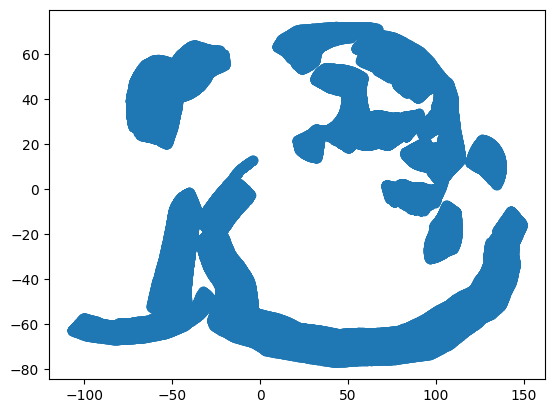

In [ ]:
plt.scatter(training_df["Longitude"],training_df['Latitude'])

In [ ]:
# len(TrainingData)

In [ ]:

# TrainingData=PK.get_plate_kinematics_gplately(training_df,
#                                         all_sz_df,
#                                         reconstruction_time=int(reconstruction_time),
#                                         window_size=int(WINDOW_SIZE),
#                                         weighted_mean=Weighted,
#                                         timesteps=TIME_STEPS,
#                                         exclude_cols=['Trench Longitude','Trench Latitude', 'Longitude'])


In [ ]:
reconstruction_time=500
# TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
# TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/Data_{reconstruction_time}.parquet")
training_df=PK.create_points_around_trench(all_subduction_df=all_sz_df,reconstruction_time=reconstruction_time,
                                tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
                                mesh_refinement_level=MESH_REFINEMENT_LEVEL)

In [ ]:
TrainingData=PK.get_plate_kinematics_gplately(training_df,
                                        all_sz_df,
                                        reconstruction_time=int(reconstruction_time),
                                        window_size=int(WINDOW_SIZE),
                                        weighted_mean=True,
                                        timesteps=5,
                                        exclude_cols=['Trench Longitude','Trench Latitude', 'Longitude','Latitude'])


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/geopandas/array.py:408: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Combining Data as a dataframe for Time=500 Ma
Combining Data as a dataframe for Time=505 Ma
Combining Data as a dataframe for Time=510 Ma
Combining Data as a dataframe for Time=515 Ma
Using weighted mean


In [ ]:
# len(TrainingData[2])

In [ ]:
subduction_df=PK.get_subductiondf(reconstruction_time,  
                                      tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
                                      velocity_delta_time=TIME_STEPS)

Using agegrid file : /Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_500Ma.nc


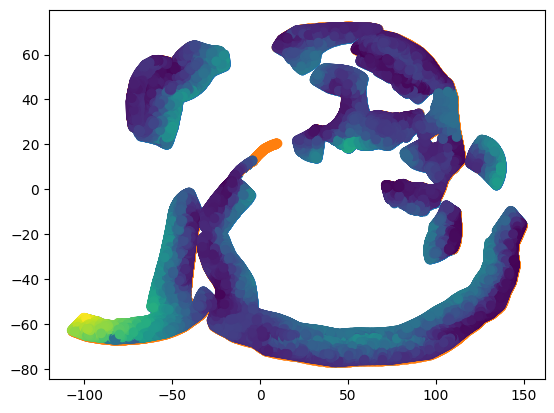

In [ ]:

# plt.scatter (TrainingData[0]['geometry'].x,TrainingData[0]['geometry'].y)
# plt.scatter(TrainingData['Trench Longitude'],TrainingData['Trench Latitude'])
# plt.scatter (TrainingData[3]['geometry'].x,TrainingData[3]['geometry'].y)
plt.scatter(training_df["Longitude"],training_df['Latitude'])
plt.scatter (subduction_df['Trench Longitude'],subduction_df['Trench Latitude'])
plt.scatter(TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Trench Distance'])

In [ ]:

Predictiondf=pd.read_parquet(f'{DEFAULT_OUTPUT_CSV}/Prediction2/Predicted_{MODEL_NAME}_{reconstruction_time}Ma.parquet')

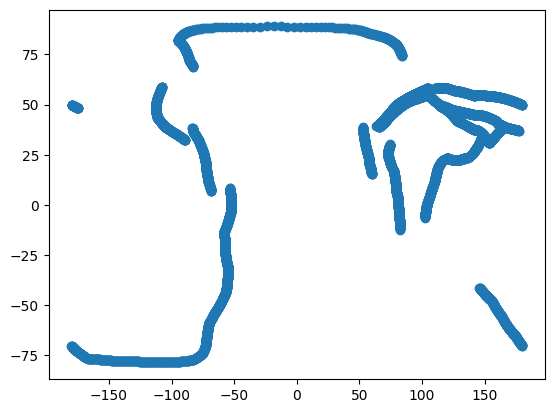

In [ ]:
plt.scatter (subduction_df['Trench Longitude'],subduction_df['Trench Latitude'])

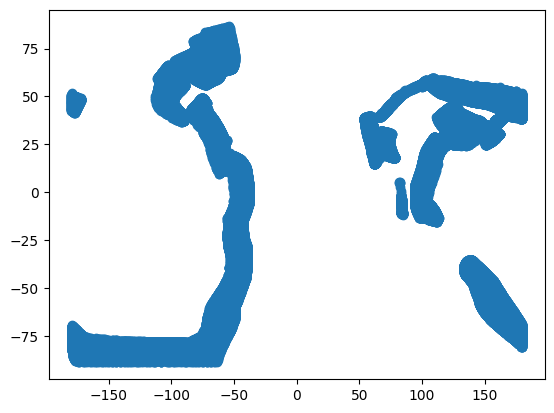

In [ ]:
plt.scatter (Predictiondf['Longitude'],Predictiondf['Latitude'])
# plt.scatter(Predictiondf['Trench Longitude'],Predictiondf['Trench Latitude'])

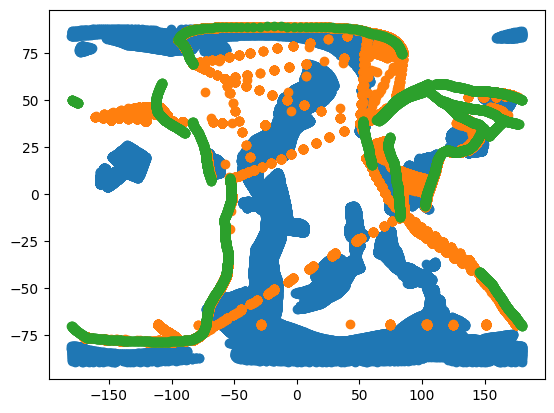

In [ ]:
plt.scatter (TrainingData['Longitude'],TrainingData['Latitude'])
# plt.scatter(TrainingData['Trench Longitude'],TrainingData['Trench Latitude'])
plt.scatter (subduction_df['Trench Longitude'],subduction_df['Trench Latitude'])

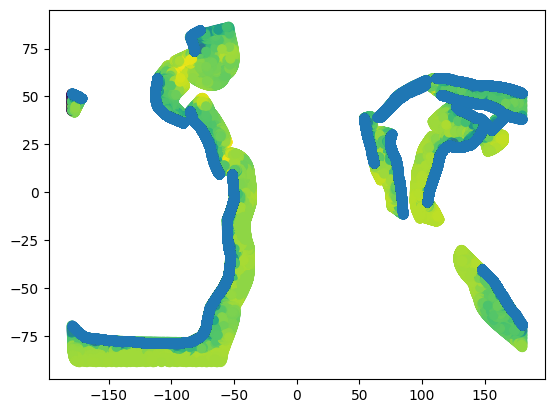

In [ ]:
plt.scatter (TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Mantle_Temp_140'])
plt.scatter(TrainingData['Trench Longitude'],TrainingData['Trench Latitude'])

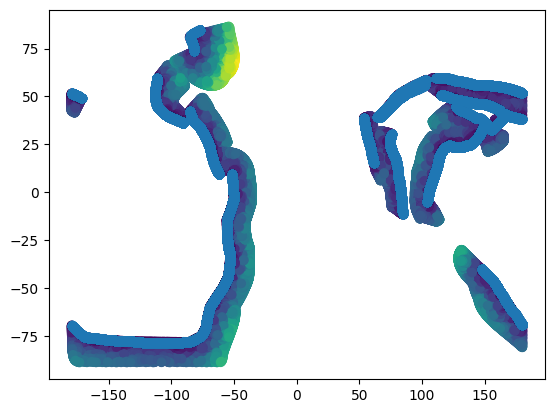

In [ ]:
plt.scatter (TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Trench Distance'])
plt.scatter(TrainingData['Trench Longitude'],TrainingData['Trench Latitude'])

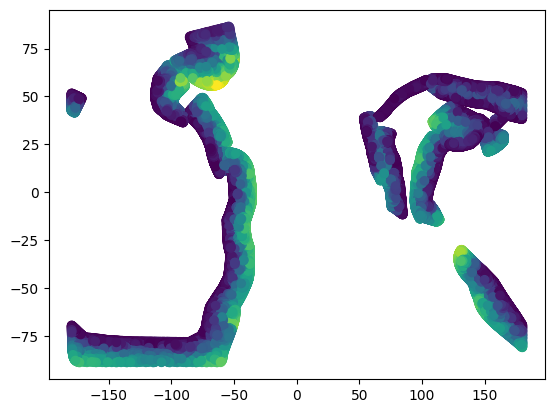

In [ ]:
plt.scatter (TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Geodesic_Distance_km'])

<Axes: >

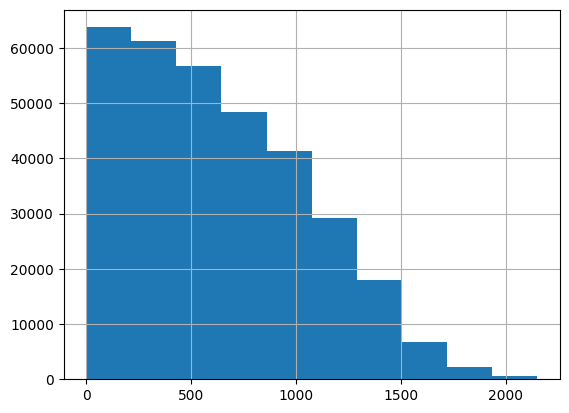

In [ ]:
TrainingData['Geodesic_Distance_km'].hist()

# Plot some of the data

### GPlately Plotting Tools

In [ ]:
reconstruction_time = 500 #Ma
gplot = gplately.PlotTopologies(PK.model, coastlines=coastlines, continents=continents, time=reconstruction_time)


In [ ]:
TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
Data_gdf=gpd.GeoDataFrame(TrainingData,geometry=gpd.points_from_xy(TrainingData['Longitude'],TrainingData['Latitude']))
Data_gdf=gpd.GeoDataFrame(TrainingData,geometry=gpd.points_from_xy(TrainingData['Longitude'],TrainingData['Latitude']),crs='EPSG:4326')


In [ ]:

def plotgdf(gdf,gplot,column=None,mollweide=False,time=0,cbar=False,quick=True,**kwargs):

    '''This function can be used to plot the reconstructed geodataframe at any time along with topologies and 
    features. If the data is large it will take a lot of time to plot. Turn quick to True to plot the data faster.
    However, there may be some issues with the colors.

    gdf: gpd.GeoDataFrame
    model: gplatey.PlateReconconstruction
    column: name of the colum to be plotted (str)
    time: reconstruction time (int)
    cbar: whether to display colorbar

    '''
    
    cmap = kwargs.get('cmap', None)
    vmin = kwargs.get('vmin', None)
    vmax = kwargs.get('vmax', None)
    label = kwargs.get('label', None)
    title=kwargs.get('title', None)
    features=kwargs.get('features',True)
    color=kwargs.get('color',None)
    markersize=kwargs.get('markersize',10)
    orientation=kwargs.get('orientation','vertical')
    shrink=kwargs.get('shrink',0.5)
    extend=kwargs.get('extend',None)
    
    central_longitude=kwargs.get('central_longitude',0)
    figsize=kwargs.get('figsize',(12,8))
    

    
    fig = plt.figure(figsize=figsize, dpi=300)
    # gplot = gplately.PlotTopologies(model, coastlines=model.coastlines, continents=model.continents, time=time)

    if mollweide:
        ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = central_longitude))
        ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))
    
        mollweide_proj = f"+proj=moll +lon_0={central_longitude} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
        gdf=gdf.to_crs(mollweide_proj)
    else:
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude = central_longitude))
        ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    
        
        
    if features:
    
        # Plot shapefile features, subduction zones and MOR boundaries at time Ma
        gplot.time = time # Ma
        gplot.plot_continents(ax, facecolor='grey', alpha=0.2)
        gplot.plot_coastlines(ax, color='skyblue',alpha=0.3)
        gplot.plot_ridges_and_transforms(ax, color='k')
        gplot.plot_trenches(ax, color='k')
        gplot.plot_subduction_teeth(ax, color='k')

        gplot.plot_ridges(ax, color='k')
        gplot.plot_transforms(ax, color='k')
        gplot.plot_misc_boundaries(ax, color='k')

    
        # Plot the GeoDataFrame
    
    if quick:
        da=df_to_NetCDF(x=gdf["Longitude"],y=gdf["Latitude"],z=gdf[column],grid_resolution=0.2)
        plot=gplot.plot_grid(ax=ax, grid=da,**{'cmap':cmap,'vmax':vmax,'vmin': vmin})
    else:
        plot = gdf.plot(ax=ax, cmap=cmap, column=column,vmax=vmax,vmin=vmin,color=color,markersize=markersize)
    

                                             # 'label':f'{column}'})
    if cbar:
        # Create a ScalarMappable object
        sm = cm.ScalarMappable(cmap=cmap)
        sm.set_array(gdf[column])
        sm.set_clim(vmin, vmax)
        
        # Add colorbar using the same Axes object used for plotting
        colorbar = plt.colorbar(sm, ax=ax, orientation=orientation,shrink=shrink,extend=extend, label=label)
        colorbar.set_label(label)
    
    ax.set_global()
    
    return ax    

In [ ]:
columns

Index(['Humid_Belt', 'Longitude', 'Latitude', 'Index', 'geometry',
       'Trench Distance', 'Convergence Rate', 'Migration Rate',
       'Subduction Velocity', 'Obliquity Angle', 'Subduction Normal Angle',
       'Subduction Length', 'Subduction Plate Velocity',
       'Subduction Plate Obliquity', 'vratio', 'Nearest Trench Edge',
       'Start Edge Trench', 'Convergence Velocity Orthogonal',
       'Convergence Velocity Parallel', 'Trench Velocity Orthogonal',
       'Trench Velocity Parallel', 'Subducting Velocity Orthogonal',
       'Subducting Velocity Parallel', 'Subducting Plate ID',
       'Trench Plate ID', 'Subduction Volume Rate', 'Plate Thickness',
       'Subduction Flux', 'Time', 'Mantle_Temp_16', 'Mantle_Temp_31',
       'Mantle_Temp_47', 'Mantle_Temp_62', 'Mantle_Temp_140',
       'Mantle_Temp_155', 'Mantle_Temp_171', 'Mantle_Temp_186',
       'Mantle_Temp_202', 'Mantle_Temp_217', 'Mantle_Temp_233',
       'Mantle_Temp_268', 'Mantle_Temp_293', 'Mantle_Temp_323',
       

/var/folders/qr/01bxwnvn05s319mx5c07sd7w0000gp/T/ipykernel_23976/3282754200.py:53: DeprecationWarning: Deprecated! The 'plot_ridges_and_transforms' function will be removed in the future GPlately releases. Update your workflow to use the 'plot_ridges' and 'plot_transforms' functions instead, otherwise your workflow will not work with the future GPlately releases.


<GeoAxes: >

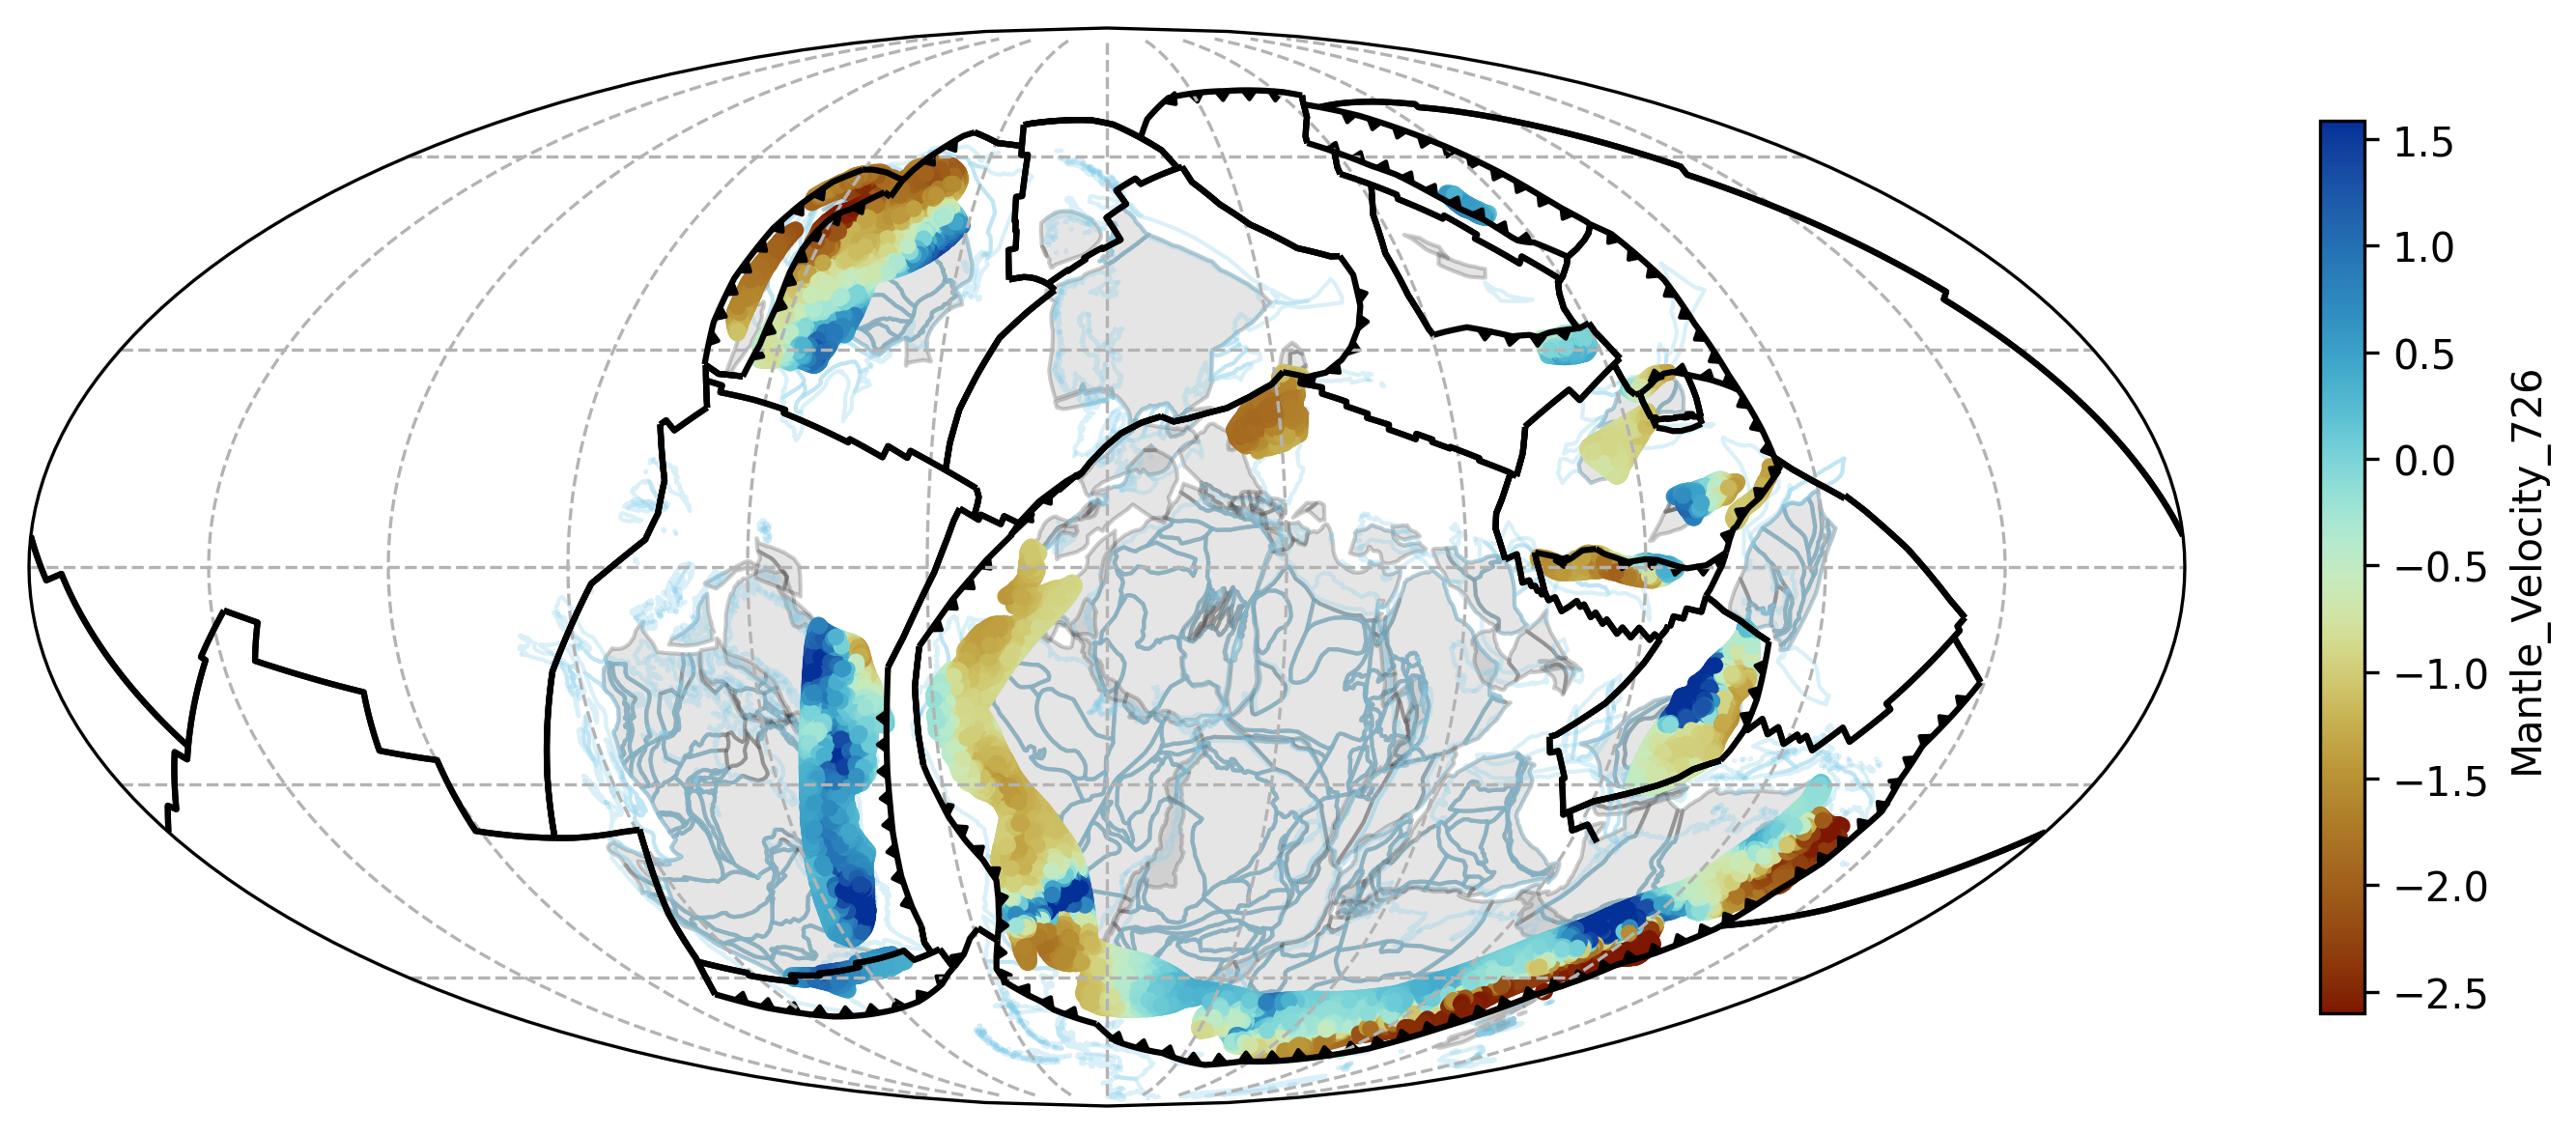

In [ ]:
k=-8
columns=Data_gdf.columns
column=columns[k]

data = Data_gdf[column]
# Calculate mean and standard deviation
mean = data.mean()
std = data.std()

# Calculate vmin and vmax
vmin = mean - 2 * std
vmax = mean + 2 * std
kwargs={'vmin':vmin,'vmax':vmax,'cmap':cmc.roma,'label':column}



plotgdf(Data_gdf,gplot=gplot,time=reconstruction_time,column=column,cbar=True,mollweide=True,quick=False,**kwargs)

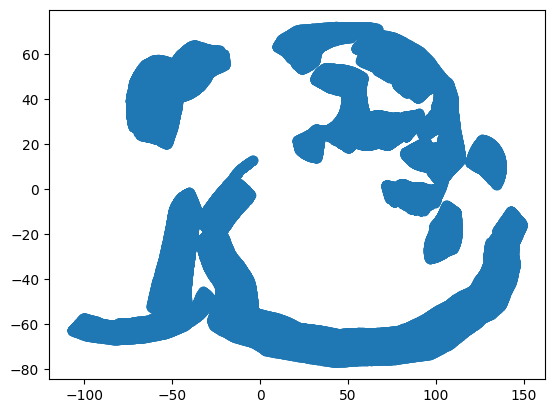

In [ ]:
plt.scatter(training_df["Longitude"],training_df['Latitude'])

In [ ]:
# plotgdf(Data_gdf,gplot=gplot,time=reconstruction_time,cbar=True,mollweide=True,quick=False,**kwargs)

In [ ]:
## Creating Seafloor age data


In [ ]:
reconstruction_time=10
print(f"Working on {reconstruction_time}")
age_grid_file = find_filename_with_number(PK.agegrid,reconstruction_time)
age_grid=xr.open_dataset(age_grid_file)

pygplates.reconstruct(continents,PK.rotation_model,"tmp.shp",reconstruction_time,anchor_plate_id=PK.anchor_plate_id)
recon_cgdf=gpd.read_file("tmp.shp")
columns=['lat','lon','Band1']
all_points=age_grid.to_dataframe().reset_index()
db_gdf=age_grid.to_dataframe().reset_index().dropna()
all_nan = all_points[all_points['Band1'].isna()]
all_nan_gdf=gpd.GeoDataFrame(all_nan,geometry=gpd.points_from_xy(all_nan['lon'],all_nan['lat']),crs="EPSG:4326")

all_within_continents=gpd.sjoin(all_nan_gdf,recon_cgdf,predicate='within',how='left')
all_within_continents=all_within_continents.dropna(subset=['ANCHOR', 'TIME', 'FILE1', 'RECONFILE1', 'PLATEID1', 'FROMAGE', 'TOAGE',
               'NAME', 'PLATEID2', 'GPGIM_TYPE', 'L_PLATE', 'R_PLATE', 'SPREAD_ASY',
               'IMPORT_AGE'])
all_within_continents['Band1']=200
combined=pd.concat([all_within_continents[columns],db_gdf[columns]])
combined_cdf=df_to_NetCDF(combined['lon'],combined['lat'],combined['Band1'])
# smoothed_data = gaussian_filter(combined_cdf, sigma=1.0)
combined_cdf= combined_cdf.interpolate_na(dim="Longitude", method="linear").interpolate_na(dim="Latitude", method='linear')
combined_cdf=combined_cdf.to_dataset(name=column_for_netcdf1)
combined_cdf.to_netcdf(f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/Age_Grid_{reconstruction_time}.nc",encoding=encoding)

Working on 10


In [ ]:
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/")

column_for_netcdf1="Lithospheric Age"
compression = {'zlib': ZLIB, 'complevel': COMPLEVEL}
encoding = {column_for_netcdf1: compression}

for reconstruction_time in range(TO_TIME,FROM_TIME+1,TIME_STEPS):
    print(f"Working on {reconstruction_time}")
    age_grid_file = find_filename_with_number(PK.agegrid,reconstruction_time)
    age_grid=xr.open_dataset(age_grid_file)
    
    pygplates.reconstruct(continents,PK.rotation_model,"tmp.shp",reconstruction_time,anchor_plate_id=PK.anchor_plate_id)
    recon_cgdf=gpd.read_file("tmp.shp")
    columns=['lat','lon','Band1']
    all_points=age_grid.to_dataframe().reset_index()
    db_gdf=age_grid.to_dataframe().reset_index().dropna()
    all_nan = all_points[all_points['Band1'].isna()]
    all_nan_gdf=gpd.GeoDataFrame(all_nan,geometry=gpd.points_from_xy(all_nan['lon'],all_nan['lat']),crs="EPSG:4326")
    
    all_within_continents=gpd.sjoin(all_nan_gdf,recon_cgdf,predicate='within',how='left')
    all_within_continents=all_within_continents.dropna(subset=['ANCHOR', 'TIME', 'FILE1', 'RECONFILE1', 'PLATEID1', 'FROMAGE', 'TOAGE',
                   'NAME', 'PLATEID2', 'GPGIM_TYPE', 'L_PLATE', 'R_PLATE', 'SPREAD_ASY',
                   'IMPORT_AGE'])
    all_within_continents['Band1']=300
    combined=pd.concat([all_within_continents[columns],db_gdf[columns]])
    combined_cdf=df_to_NetCDF(combined['lon'],combined['lat'],combined['Band1'])
    # smoothed_data = gaussian_filter(combined_cdf, sigma=1.0)
    combined_cdf= combined_cdf.interpolate_na(dim="Longitude", method="linear").interpolate_na(dim="Latitude", method='linear')
    combined_cdf=combined_cdf.to_dataset(name=column_for_netcdf1)
    combined_cdf.to_netcdf(f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/Age_Grid_{reconstruction_time}.nc",encoding=encoding)

Working on 0
Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10
Working on 11
Working on 12
Working on 13
Working on 14
Working on 15
Working on 16
Working on 17
Working on 18
Working on 19
Working on 20
Working on 21
Working on 22
Working on 23
Working on 24
Working on 25
Working on 26
Working on 27
Working on 28
Working on 29
Working on 30
Working on 31
Working on 32
Working on 33
Working on 34
Working on 35
Working on 36
Working on 37
Working on 38
Working on 39
Working on 40
Working on 41
Working on 42
Working on 43
Working on 44
Working on 45
Working on 46
Working on 47
Working on 48
Working on 49
Working on 50
Working on 51
Working on 52
Working on 53
Working on 54
Working on 55
Working on 56
Working on 57
Working on 58
Working on 59
Working on 60
Working on 61
Working on 62
Working on 63
Working on 64
Working on 65
Working on 66
Working on 67
Working on 68
Working on 69
Working on 70
Working on 71
Wo

Working on 347


Working on 348


Working on 349


Working on 350


Working on 351
Working on 352
Working on 353
Working on 354
Working on 355
Working on 356
Working on 357
Working on 358
Working on 359
Working on 360
Working on 361
Working on 362
Working on 363
Working on 364
Working on 365
Working on 366
Working on 367
Working on 368
Working on 369
Working on 370
Working on 371
Working on 372
Working on 373
Working on 374
Working on 375
Working on 376
Working on 377
Working on 378
Working on 379
Working on 380
Working on 381
Working on 382
Working on 383
Working on 384
Working on 385
Working on 386
Working on 387
Working on 388
Working on 389
Working on 390
Working on 391
Working on 392
Working on 393
Working on 394
Working on 395
Working on 396
Working on 397
Working on 398
Working on 399
Working on 400
Working on 401
Working on 402
Working on 403
Working on 404
Working on 405
Working on 406
Working on 407
Working on 408
Working on 409
Working on 410
Working on 411
Working on 412
Working on 413
Working on 414
Working on 415
Working on 416
Working on

In [ ]:
age_grid_file = find_filename_with_number(PK.agegrid, reconstruction_time)
age_grid = xr.open_dataset(age_grid_file)
age_grid

<xarray.Dataset> Size: 26MB
Dimensions:  (lat: 1801, lon: 3601)
Coordinates:
  * lon      (lon) float64 29kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
Data variables:
    z        (lat, lon) float32 26MB ...
Attributes:
    Conventions:  CF-1.7
    history:      sphinterpolate /tmp/tmple_amre2 -G../output/AgeGrids/unmask...
    GMT_version:  6.2.0 [64-bit]

In [20]:
def df_to_NetCDF(x,y,z, statistic='mean',  grid_resolution=0.1, clip=(None,None)):
    # Define bin edges (lat and lon) based on your data range and desired bin sizes
    lon_bin_edges = np.arange(x.min(), x.max() + grid_resolution, grid_resolution)
    lat_bin_edges = np.arange(y.min(), y.max()+ grid_resolution, grid_resolution)

    # Calculate binned statistics (mean, median, etc.)
    arr, _, _, _ = binned_statistic_2d(
        x,
        y,
        values=z,
        statistic=statistic,
        bins=[lon_bin_edges, lat_bin_edges],
    )
    
    arr = arr.T
    if clip[0] !=None:
        arr[arr<clip[0]]=np.nan
    if clip[1] !=None:
        arr[arr>clip[1]]=np.nan
    
    # Replace NaN values with the chosen nan_replacement value
    # arr[np.isnan(arr)] = nan_replacement
    
    # Calculate midpoint of latitude bins
    lat_midpoints = lat_bin_edges[:-1] + grid_resolution / 2
    lon_midpoints = lon_bin_edges[:-1] + grid_resolution / 2
    
    da = xr.DataArray(
        data=arr,
        coords={'Latitude': lat_midpoints, 'Longitude': lon_midpoints},
        dims=['Latitude', 'Longitude']
    )
    return da

In [ ]:
combined['lat'].astype('float')

0         -90.0
1         -90.0
2         -90.0
3         -90.0
4         -90.0
           ... 
6485396    90.0
6485397    90.0
6485398    90.0
6485399    90.0
6485400    90.0
Name: lat, Length: 6485401, dtype: float64

In [ ]:
x=combined['lon'].values
y=combined['lat'].values.tolist()     
z=combined['z'].values.tolist()     
grid_resolution=0.1
statistic="mean"

In [ ]:
x.min()

np.float64(-180.0)

In [ ]:
lon_bin_edges = np.arangefloat(x.min(), x.max() + grid_resolution, grid_resolution)
lat_bin_edges = np.arange(y.min(), y.max()+ grid_resolution, grid_resolution)

# Calculate binned statistics (mean, median, etc.)
arr, _, _, _ = binned_statistic_2d(
    x,
    y,
    values=z,
    statistic=statistic,
    bins=[lon_bin_edges, lat_bin_edges],
)

arr = arr.T
if clip[0] !=None:
    arr[arr<clip[0]]=np.nan
if clip[1] !=None:
    arr[arr>clip[1]]=np.nan

# Replace NaN values with the chosen nan_replacement value
# arr[np.isnan(arr)] = nan_replacement

# Calculate midpoint of latitude bins
lat_midpoints = lat_bin_edges[:-1] + grid_resolution / 2
lon_midpoints = lon_bin_edges[:-1] + grid_resolution / 2

da = xr.DataArray(
    data=arr,
    coords={'Latitude': lat_midpoints, 'Longitude': lon_midpoints},
    dims=['Latitude', 'Longitude']
)

AttributeError: 'list' object has no attribute 'min'

In [32]:
PK.agegrid

'/Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked'

In [35]:

age_grid_masked="/Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked"
# 1. Load age grid
age_grid_file = find_filename_with_number(age_grid_masked, reconstruction_time)
print(age_grid_file)

/Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/unmasked/seafloor_age_10Ma.nc


In [40]:
print(f"Working on {reconstruction_time}")

age_grid_masked="/Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/masked"
# 1. Load age grid
age_grid_file = find_filename_with_number(age_grid_masked, reconstruction_time)
age_grid = xr.open_dataset(age_grid_file)

# 2. Reconstruct continents (use unique tmp file per job)
tmp_file = f"tmp_{reconstruction_time}.shp"
pygplates.reconstruct(
    continents,
    PK.rotation_model,
    tmp_file,
    reconstruction_time,
    anchor_plate_id=PK.anchor_plate_id
)
recon_cgdf = gpd.read_file(tmp_file)

# 3. Prepare point data
columns = ['lat', 'lon', 'z']
all_points = age_grid.to_dataframe().reset_index()
db_gdf = all_points.dropna()
all_nan = all_points[all_points['z'].isna()]
all_nan_gdf = gpd.GeoDataFrame(
    all_nan,
    geometry=gpd.points_from_xy(all_nan['lon'], all_nan['lat']),
    crs="EPSG:4326"
)

# 4. Spatial join with continents
all_within_continents = gpd.sjoin(
    all_nan_gdf,
    recon_cgdf,
    predicate='within',
    how='left'
)
all_within_continents = all_within_continents.dropna(
    subset=['ANCHOR', 'TIME', 'FILE1', 'RECONFILE1', 'PLATEID1', 'FROMAGE', 'TOAGE',
            'NAME', 'PLATEID2', 'GPGIM_TYPE', 'L_PLATE', 'R_PLATE', 'SPREAD_ASY',
            'IMPORT_AGE']
)
all_within_continents['z'] = 300

# 5. Combine with valid values
combined = pd.concat([all_within_continents[columns], db_gdf[columns]])
combined_cdf = df_to_NetCDF(combined['lon'].astype('float'), combined['lat'].astype('float'), combined['z'].astype('float'))

# 6. Interpolation
combined_cdf = combined_cdf.interpolate_na(dim="Longitude", method="linear") \
                            .interpolate_na(dim="Latitude", method='linear')

# 7. Save to NetCDF
# combined_cdf = combined_cdf.to_dataset(name=column_for_netcdf1)
# output_file = f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/Age_Grid_{reconstruction_time}.nc"
# combined_cdf.to_netcdf(output_file, encoding=encoding)


Working on 10


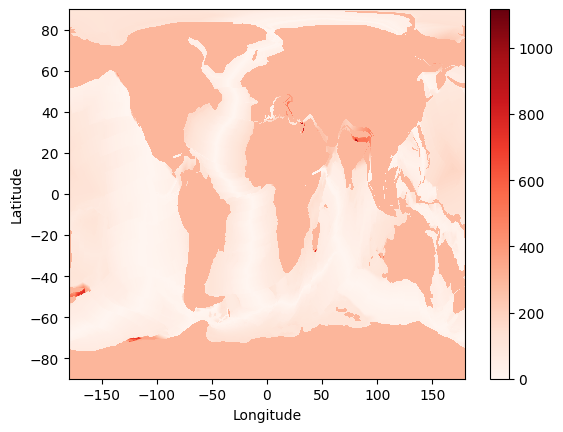

In [42]:
combined_cdf.plot(cmap='Reds')

In [ ]:
combined['lon'].values.max()

np.float64(180.0)

In [44]:
from joblib import Parallel, delayed
import geopandas as gpd
import xarray as xr
import pandas as pd
import pygplates
import os

# Ensure output directory exists
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/")

column_for_netcdf1 = "Lithospheric Age"
compression = {'zlib': ZLIB, 'complevel': COMPLEVEL}
encoding = {column_for_netcdf1: compression}
age_grid_masked="/Volumes/SatyamData/Merdith1Ga/AgeGrid_1Ga_OptimisedMantleFrame_run48/masked"

def process_reconstruction_time(reconstruction_time):
    print(f"Working on {reconstruction_time}")
    
    # 1. Load age grid
    age_grid_file = find_filename_with_number(age_grid_masked, reconstruction_time)
    age_grid = xr.open_dataset(age_grid_file)
    
    # 2. Reconstruct continents (use unique tmp file per job)
    tmp_file = f"tmp_{reconstruction_time}.shp"
    pygplates.reconstruct(
        continents,
        PK.rotation_model,
        tmp_file,
        reconstruction_time,
        anchor_plate_id=PK.anchor_plate_id
    )
    recon_cgdf = gpd.read_file(tmp_file)
    
    # 3. Prepare point data
    columns = ['lat', 'lon', 'z']
    all_points = age_grid.to_dataframe().reset_index()
    db_gdf = all_points.dropna()
    all_nan = all_points[all_points['z'].isna()]
    all_nan_gdf = gpd.GeoDataFrame(
        all_nan,
        geometry=gpd.points_from_xy(all_nan['lon'], all_nan['lat']),
        crs="EPSG:4326"
    )
    
    # 4. Spatial join with continents
    all_within_continents = gpd.sjoin(
        all_nan_gdf,
        recon_cgdf,
        predicate='within',
        how='left'
    )
    all_within_continents = all_within_continents.dropna(
        subset=['ANCHOR', 'TIME', 'FILE1', 'RECONFILE1', 'PLATEID1', 'FROMAGE', 'TOAGE',
                'NAME', 'PLATEID2', 'GPGIM_TYPE', 'L_PLATE', 'R_PLATE', 'SPREAD_ASY',
                'IMPORT_AGE']
    )
    all_within_continents['z'] = 200
    
    # 5. Combine with valid values
    combined = pd.concat([all_within_continents[columns], db_gdf[columns]])
    combined_cdf = df_to_NetCDF(combined['lon'], combined['lat'], combined['z'])
    
    # 6. Interpolation
    combined_cdf = combined_cdf.interpolate_na(dim="Longitude", method="linear") \
                               .interpolate_na(dim="Latitude", method='linear')
    
    # 7. Save to NetCDF
    combined_cdf = combined_cdf.to_dataset(name=column_for_netcdf1)
    output_file = f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/Age_Grid_{reconstruction_time}.nc"
    combined_cdf.to_netcdf(output_file, encoding=encoding)
    
    # 8. Clean up tmp shapefile files (multiple sidecar files get written by geopandas)
    for ext in [".shp", ".dbf", ".shx", ".cpg", ".prj"]:
        f = tmp_file.replace(".shp", ext)
        if os.path.exists(f):
            os.remove(f)


# Run in parallel
Parallel(n_jobs=-1, backend="loky")(
    delayed(process_reconstruction_time)(reconstruction_time)
    for reconstruction_time in range(TO_TIME, FROM_TIME + 1, TIME_STEPS)
)


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 0


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 1


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 2


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 3


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 4
Working on 5
Working on 6
Working on 7
Working on 8


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 9
Working on 10


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 11
Working on 12


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 13
Working on 14


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 15
Working on 16
Working on 17


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 18
Working on 19
Working on 20
Working on 21
Working on 22
Working on 23
Working on 24
Working on 25


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 26


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 27
Working on 28
Working on 29


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 30
Working on 31


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 32
Working on 33


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 34
Working on 35


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 36


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 37
Working on 38
Working on 39


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 40
Working on 41
Working on 42
Working on 43


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 44
Working on 45
Working on 46
Working on 47
Working on 48


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 49
Working on 50
Working on 51


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 52
Working on 53
Working on 54
Working on 55


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 56
Working on 57


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 58
Working on 59
Working on 60


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 61
Working on 62
Working on 63
Working on 64
Working on 65
Working on 66
Working on 67
Working on 68
Working on 69
Working on 70


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 71
Working on 72
Working on 73


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 74


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 75


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 76
Working on 77


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 78
Working on 79
Working on 80
Working on 81


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 82
Working on 83
Working on 84


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 85


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 86
Working on 87


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 88
Working on 89


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 90


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 91
Working on 92
Working on 93
Working on 94
Working on 95
Working on 96
Working on 97
Working on 98
Working on 99
Working on 100


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 101


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 102


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 103


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 104


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 105


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 106
Working on 107
Working on 108
Working on 109
Working on 110


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 111
Working on 112


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 113
Working on 114
Working on 115
Working on 116
Working on 117
Working on 118
Working on 119
Working on 120


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 121
Working on 122
Working on 123
Working on 124
Working on 125
Working on 126
Working on 127
Working on 128


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 129
Working on 130
Working on 131
Working on 132
Working on 133


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 134
Working on 135
Working on 136
Working on 137
Working on 138


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 139


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 140
Working on 141
Working on 142
Working on 143


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 144
Working on 145


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 146


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 147
Working on 148


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 149
Working on 150
Working on 151
Working on 152


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 153
Working on 154
Working on 155
Working on 156
Working on 157


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 158
Working on 159
Working on 160
Working on 161
Working on 162
Working on 163
Working on 164
Working on 165
Working on 166
Working on 167
Working on 168


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 169
Working on 170
Working on 171
Working on 172
Working on 173
Working on 174
Working on 175
Working on 176
Working on 177
Working on 178
Working on 179
Working on 180
Working on 181
Working on 182
Working on 183
Working on 184
Working on 185
Working on 186


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 187
Working on 188
Working on 189


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 190
Working on 191
Working on 192
Working on 193
Working on 194
Working on 195
Working on 196


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 197


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 198
Working on 199
Working on 200
Working on 201


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 202
Working on 203
Working on 204
Working on 205


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 206


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 207
Working on 208
Working on 209
Working on 210


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 211
Working on 212
Working on 213
Working on 214
Working on 215


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 216
Working on 217
Working on 218
Working on 219
Working on 220
Working on 221
Working on 222
Working on 223
Working on 224


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 225


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 226
Working on 227
Working on 228
Working on 229
Working on 230
Working on 231
Working on 232


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 233
Working on 234
Working on 235
Working on 236


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 237
Working on 238
Working on 239
Working on 240


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 241


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 242
Working on 243
Working on 244
Working on 245
Working on 246
Working on 247
Working on 248
Working on 249
Working on 250
Working on 251
Working on 252


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 253
Working on 254
Working on 255
Working on 256


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 257


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 258
Working on 259
Working on 260
Working on 261


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 262
Working on 263
Working on 264
Working on 265
Working on 266


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 267
Working on 268
Working on 269
Working on 270
Working on 271
Working on 272
Working on 273
Working on 274
Working on 275
Working on 276


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 277
Working on 278
Working on 279
Working on 280
Working on 281


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 282
Working on 283


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 284
Working on 285
Working on 286
Working on 287
Working on 288
Working on 289


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 290
Working on 291
Working on 292
Working on 293
Working on 294


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 295
Working on 296
Working on 297


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 298
Working on 299
Working on 300
Working on 301
Working on 302


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 303
Working on 304


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 305
Working on 306
Working on 307


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 308
Working on 309
Working on 310
Working on 311
Working on 312
Working on 313
Working on 314
Working on 315
Working on 316
Working on 317
Working on 318


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 319
Working on 320


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 321
Working on 322


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 323
Working on 324


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 325


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 326


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 327
Working on 328
Working on 329
Working on 330
Working on 331
Working on 332
Working on 333
Working on 334
Working on 335


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 336
Working on 337


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 338
Working on 339
Working on 340
Working on 341


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 342
Working on 343
Working on 344
Working on 345
Working on 346
Working on 347
Working on 348
Working on 349
Working on 350


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 351


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 352
Working on 353


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 354


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 355
Working on 356
Working on 357
Working on 358
Working on 359
Working on 360
Working on 361
Working on 362


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 363


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 364


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 365
Working on 366


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 367


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 368
Working on 369


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 370
Working on 371
Working on 372
Working on 373
Working on 374


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 375
Working on 376
Working on 377
Working on 378


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 379
Working on 380
Working on 381
Working on 382
Working on 383
Working on 384
Working on 385
Working on 386
Working on 387
Working on 388
Working on 389


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 390
Working on 391
Working on 392
Working on 393
Working on 394
Working on 395
Working on 396
Working on 397
Working on 398
Working on 399


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 400
Working on 401
Working on 402
Working on 403
Working on 404
Working on 405
Working on 406
Working on 407
Working on 408
Working on 409
Working on 410
Working on 411
Working on 412
Working on 413


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 414
Working on 415
Working on 416
Working on 417
Working on 418


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 419
Working on 420
Working on 421
Working on 422
Working on 423
Working on 424
Working on 425
Working on 426
Working on 427
Working on 428
Working on 429
Working on 430
Working on 431
Working on 432
Working on 433


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 434
Working on 435
Working on 436
Working on 437
Working on 438
Working on 439
Working on 440
Working on 441


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 442
Working on 443
Working on 444
Working on 445


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 446
Working on 447
Working on 448
Working on 449
Working on 450
Working on 451
Working on 452
Working on 453
Working on 454
Working on 455
Working on 456
Working on 457
Working on 458
Working on 459
Working on 460
Working on 461


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 462
Working on 463
Working on 464
Working on 465


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 466
Working on 467
Working on 468
Working on 469
Working on 470
Working on 471
Working on 472


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 473
Working on 474
Working on 475
Working on 476
Working on 477


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 478
Working on 479
Working on 480
Working on 481


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 482
Working on 483
Working on 484
Working on 485
Working on 486
Working on 487
Working on 488
Working on 489
Working on 490
Working on 491
Working on 492
Working on 493


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 494
Working on 495
Working on 496
Working on 497
Working on 498
Working on 499
Working on 500
Working on 501
Working on 502
Working on 503
Working on 504
Working on 505


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 506
Working on 507
Working on 508
Working on 509
Working on 510
Working on 511


/Users/ssin4735/miniforge3/envs/EBMTest311/lib/python3.11/site-packages/ptt/documentation.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Working on 512
Working on 513
Working on 514
Working on 515
Working on 516
Working on 517
Working on 518
Working on 519
Working on 520
Working on 521
Working on 522
Working on 523
Working on 524
Working on 525


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [45]:
from joblib import Parallel, delayed
import pandas as pd

def process_time(reconstruction_time):
    try:
        print(f"Working in {reconstruction_time} Ma")
        
        # Load training data
        TrainingData = pd.read_parquet(
            f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma copy/Processed_Data_{reconstruction_time}.parquet"
        )
        
        # Load seafloor grid
        age_grid_file = find_filename_with_number(
            f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/",
            reconstruction_time
        )
        
        # Initialize raster object
        Lithospheric_Age = BhuRaster(folder_location=age_grid_file, Raster_Type="Lithospheric_Age")
        
        # Merge raster parameters into training data
        TrainingData = Lithospheric_Age.get_parameters(TrainingData)
        
        # Save updated parquet
        TrainingData.to_parquet(
            f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet"
        )
    except Exception as e:
        print(e)
        pass


# Run in parallel (use all cores, switch to n_jobs=4 if too memory heavy)
Parallel(n_jobs=-1, backend="loky")(
    delayed(process_time)(reconstruction_time)
    for reconstruction_time in range(TO_TIME, FROM_TIME + 1, TIME_STEPS)
)


Working in 0 Ma
Working in 1 Ma
Working in 2 Ma
Working in 4 Ma
Working in 3 Ma
Working in 5 Ma
Working in 6 Ma
Working in 7 Ma
Working in 8 Ma
Working in 9 Ma
Working in 10 Ma
Working in 11 Ma
Working in 12 Ma
Working in 13 Ma
Working in 14 Ma
Working in 15 Ma
Working in 16 Ma
Working in 17 Ma
[Errno 2] No such file or directory: '/Volumes/SatyamData/Merdith1Ga/1Ga_Reconstructions/Paleotopography/CSV/Processed_15_Ma copy/Processed_Data_17.parquet'
Working in 18 Ma
Working in 19 Ma
Working in 20 Ma
Working in 21 Ma
Working in 22 Ma
Working in 23 Ma
Working in 24 Ma
Working in 25 Ma
Working in 26 Ma
Working in 27 Ma
Working in 28 Ma
Working in 29 Ma
Working in 30 Ma
Working in 31 Ma
Working in 32 Ma
Working in 33 Ma
Working in 34 Ma
Working in 35 Ma
Working in 36 Ma
Working in 37 Ma
Working in 38 Ma
Working in 39 Ma
Working in 40 Ma
Working in 41 Ma
Working in 42 Ma
Working in 43 Ma
Working in 44 Ma
Working in 45 Ma
Working in 46 Ma
Working in 47 Ma
Working in 48 Ma
Working in 49 Ma
Wor

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet"

'/Volumes/Satyam/Paleotopography/CSV/Processed_25_Ma/Processed_Data_525.parquet'

In [ ]:
reconstruction_time=11
print(f"Working in {reconstruction_time} Ma")
# Load the training data from a parquet file corresponding to the reconstruction time
TrainingData = pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma BeforeMC/Processed_Data_{reconstruction_time}.parquet")

# Drop rows with missing values
# TrainingData = TrainingData.dropna()

age_grid_file = find_filename_with_number(f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/",reconstruction_time)
# Initialize BhuRaster with the ETOPO file and type
Lithospheric_Age = BhuRaster(folder_location=age_grid_file, Raster_Type="Lithospheric_Age")

# Get additional parameters from the ETOPO raster and merge them into the training data
TrainingData = Lithospheric_Age.get_parameters(TrainingData)
TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
# break


Working in 11 Ma


In [ ]:
TrainingData

Humid_Belt    Index  Convergence Rate  Migration Rate  \
21               15  2340916          0.024256       -0.012318   
26                0  1807690          0.009324       -0.014394   
32                0   573478          0.042459       -0.028902   
43                0   882175          0.020188        0.007026   
43                0   882175          0.020188        0.007026   
...             ...      ...               ...             ...   
2621269           0  2451758          0.041561        0.003717   
2621287           0   941871          0.023787        0.000994   
2621297           0   443163          0.048218        0.003969   
2621386           0  2077845          0.080699       -0.034275   
2621387           0   466684          0.081496       -0.034880   

         Subduction Velocity  Obliquity Angle  Subduction Normal Angle  \
21                  0.049049         8.748979                96.153235   
26                 -0.027225      -122.744340               274.853739   
32                  0.057692       -57.515355                62.137197   
43                  0.021459       -15.901184                23.033082   
43                  0.021459       -15.901184                23.033082   
...                      ...              ...                      ...   
2621269             0.042801       -15.179905               147.463873   
2621287             0.022491       -64.955671               125.421107   
2621297             0.048899        -7.901580               141.209513   
2621386             0.082819        -7.774625               265.818054   
2621387             0.083598        -7.645220               265.819352   

         Subduction Length  Subduction Plate Velocity  \
21            10751.791489                   0.446854   
26            10225.472773                   4.438398   
32             9898.896438                   0.371073   
43            10139.790387                  -2.921682   
43            10139.790387                  -2.921682   
...                    ...                        ...   
2621269        9165.939982                  -4.640666   
2621287        9920.182720                  -2.246895   
2621297       10551.039529                  -5.305605   
2621386       10781.049515                  -5.465305   
2621387       10781.049512                  -5.482732   

         Subduction Plate Obliquity  ...  Viscocity_726  Viscocity_798  \
21                        57.388483  ...            NaN            NaN   
26                      -124.351923  ...            NaN            NaN   
32                       -82.151839  ...            NaN            NaN   
43                        10.545058  ...            NaN            NaN   
43                        10.545058  ...            NaN            NaN   
...                             ...  ...            ...            ...   
2621269                  -12.596354  ...            NaN            NaN   
2621287                   52.203078  ...            NaN            NaN   
2621297                   -7.427194  ...            NaN            NaN   
2621386                   30.163151  ...            NaN            NaN   
2621387                   30.076904  ...            NaN            NaN   

         Viscocity_874  Viscocity_954  Viscocity_1040  \
21                 NaN            NaN             NaN   
26                 NaN            NaN             NaN   
32                 NaN            NaN             NaN   
43                 NaN            NaN             NaN   
43                 NaN            NaN             NaN   
...                ...            ...             ...   
2621269            NaN            NaN             NaN   
2621287            NaN            NaN             NaN   
2621297            NaN            NaN             NaN   
2621386            NaN            NaN             NaN   
2621387            NaN            NaN             NaN   

                                                  geometry     DistH

In [ ]:
# Define the time point for reconstruction
# reconstruction_time = 0

for reconstruction_time in range(TO_TIME,FROM_TIME+1,TIME_STEPS):
    print(f"Working in {reconstruction_time} Ma")
    # Load the training data from a parquet file corresponding to the reconstruction time
    TrainingData = pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma BeforeMC/Processed_Data_{reconstruction_time}.parquet")
    
    # Drop rows with missing values
    # TrainingData = TrainingData.dropna()
    
    age_grid_file = find_filename_with_number(f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/",reconstruction_time)
    # Initialize BhuRaster with the ETOPO file and type
    Lithospheric_Age = BhuRaster(folder_location=age_grid_file, Raster_Type="Lithospheric_Age")
    
    # Get additional parameters from the ETOPO raster and merge them into the training data
    TrainingData = Lithospheric_Age.get_parameters(TrainingData)
    TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
    # break


Working in 0 Ma
Working in 1 Ma
Working in 2 Ma
Working in 3 Ma
Working in 4 Ma
Working in 5 Ma
Working in 6 Ma
Working in 7 Ma
Working in 8 Ma
Working in 9 Ma
Working in 10 Ma
Working in 11 Ma
Working in 12 Ma
Working in 13 Ma
Working in 14 Ma
Working in 15 Ma
Working in 16 Ma
Working in 17 Ma
Working in 18 Ma
Working in 19 Ma
Working in 20 Ma
Working in 21 Ma
Working in 22 Ma
Working in 23 Ma
Working in 24 Ma
Working in 25 Ma
Working in 26 Ma
Working in 27 Ma
Working in 28 Ma
Working in 29 Ma
Working in 30 Ma
Working in 31 Ma
Working in 32 Ma
Working in 33 Ma
Working in 34 Ma
Working in 35 Ma
Working in 36 Ma
Working in 37 Ma
Working in 38 Ma
Working in 39 Ma
Working in 40 Ma
Working in 41 Ma
Working in 42 Ma
Working in 43 Ma
Working in 44 Ma
Working in 45 Ma
Working in 46 Ma
Working in 47 Ma
Working in 48 Ma
Working in 49 Ma
Working in 50 Ma
Working in 51 Ma
Working in 52 Ma
Working in 53 Ma
Working in 54 Ma
Working in 55 Ma
Working in 56 Ma
Working in 57 Ma
Working in 58 Ma
Working

In [10]:

reconstruction_time=10
TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
Data_gdf=gpd.GeoDataFrame(TrainingData,geometry=gpd.points_from_xy(TrainingData['Longitude'],TrainingData['Latitude']),crs='EPSG:4326')


In [11]:
Data_gdf

Humid_Belt   Longitude      Latitude     Index  \
0               15  126.000000  0.000000e+00       0.0   
1                0 -108.000000  3.171747e+01       1.0   
2                0   49.613822  4.635307e+01       2.0   
3               15  108.000000  9.828454e-16       3.0   
4                0  134.267699 -1.604506e+01       4.0   
...            ...         ...           ...       ...   
289645           0  -63.676938 -7.476448e+01  289645.0   
289646           0  -62.921529 -7.462673e+01  289646.0   
289647           0  -72.000000 -6.364593e+01  289647.0   
289648           0 -179.072557 -2.720179e+01  289648.0   
289649           0 -179.339471 -2.687886e+01  289649.0   

                            geometry  Trench Distance  Convergence Rate  \
0                      POINT (126 0)     1.591537e+05          0.039523   
1              POINT (-108 31.71747)     5.722957e+05          0.034652   
2          POINT (49.61382 46.35307)     1.192733e+06          0.022447   
3            POINT (108 9.82845e-16)     7.337987e+05          0.038762   
4         POINT (134.2677 -16.04506)     1.140468e+06          0.018925   
...                              ...              ...               ...   
289645   POINT (-63.67694 -74.76448)     1.167555e+06          0.038851   
289646   POINT (-62.92153 -74.62673)     1.159794e+06          0.038851   
289647         POINT (-72 -63.64593)     1.487687e+05          0.041258   
289648  POINT (-179.07256 -27.20179)     1.101643e+05          0.075607   
289649  POINT (-179.33947 -26.87886)     1.288973e+05          0.076136   

        Migration Rate  Subduction Velocity  Obliquity Angle  ...  \
0            -0.033095             0.028348       -56.707137  ...   
1            -0.018426             0.029681       -55.347291  ...   
2             0.004805             0.024675       -21.967094  ...   
3             0.003494             0.035045       -38.646562  ...   
4            -0.016338             0.033744         0.353536  ...   
...                ...                  ...              ...  ...   
289645        0.001733             0.039434        -3.495050  ...   
289646        0.001733             0.039434        -3.495050  ...   
289647        0.002055             0.041852        -3.304765  ...   
289648       -0.020892             0.076394        -5.985997  ...   
289649       -0.020676             0.077111        -7.286295  ...   

        Mantle_Velocity_660  Mantle_Velocity_726  Mantle_Velocity_798  \
0                 -1.319924            -1.393305            -1.464883   
1                 -0.872940            -0.698038            -0.479133   
2                  0.368762             0.316606             0.265343   
3                 -1.304880            -1.356055            -1.394694   
4                 -1.532064            -1.531647            -1.520181   
...                     ...                  ...                  ...   
289645            -0.868436            -0.868912            -0.857317   
289646            -0.878814            -0.880634            -0.870214   
289647            -0.958971            -1.010500            -0.989523   
289648            -1.452234            -1.336320            -1.210888   
289649            -1.457930            -1.339911            -1.215790   

        Mantle_Velocity_874  Mantle_Velocity_954  Mantle_Velocity_1040  \
0                 -1.526148            -1.572953             -1.591797   
1                 -0.251016            -0.072160              0.055182   
2                  0.206157             0.139911              0.070914   
3                 -1.410009            -1.408142             -1.395125   
4                 -1.501362            -1.473851             -1.433222   
...                     ...                  ...                   ...   
289645            -0.847345            -0.843203             -0.842482   
289646            -0.859504            -0.855738             -0.854975   
289647            -0.947800           

<GeoAxes: >

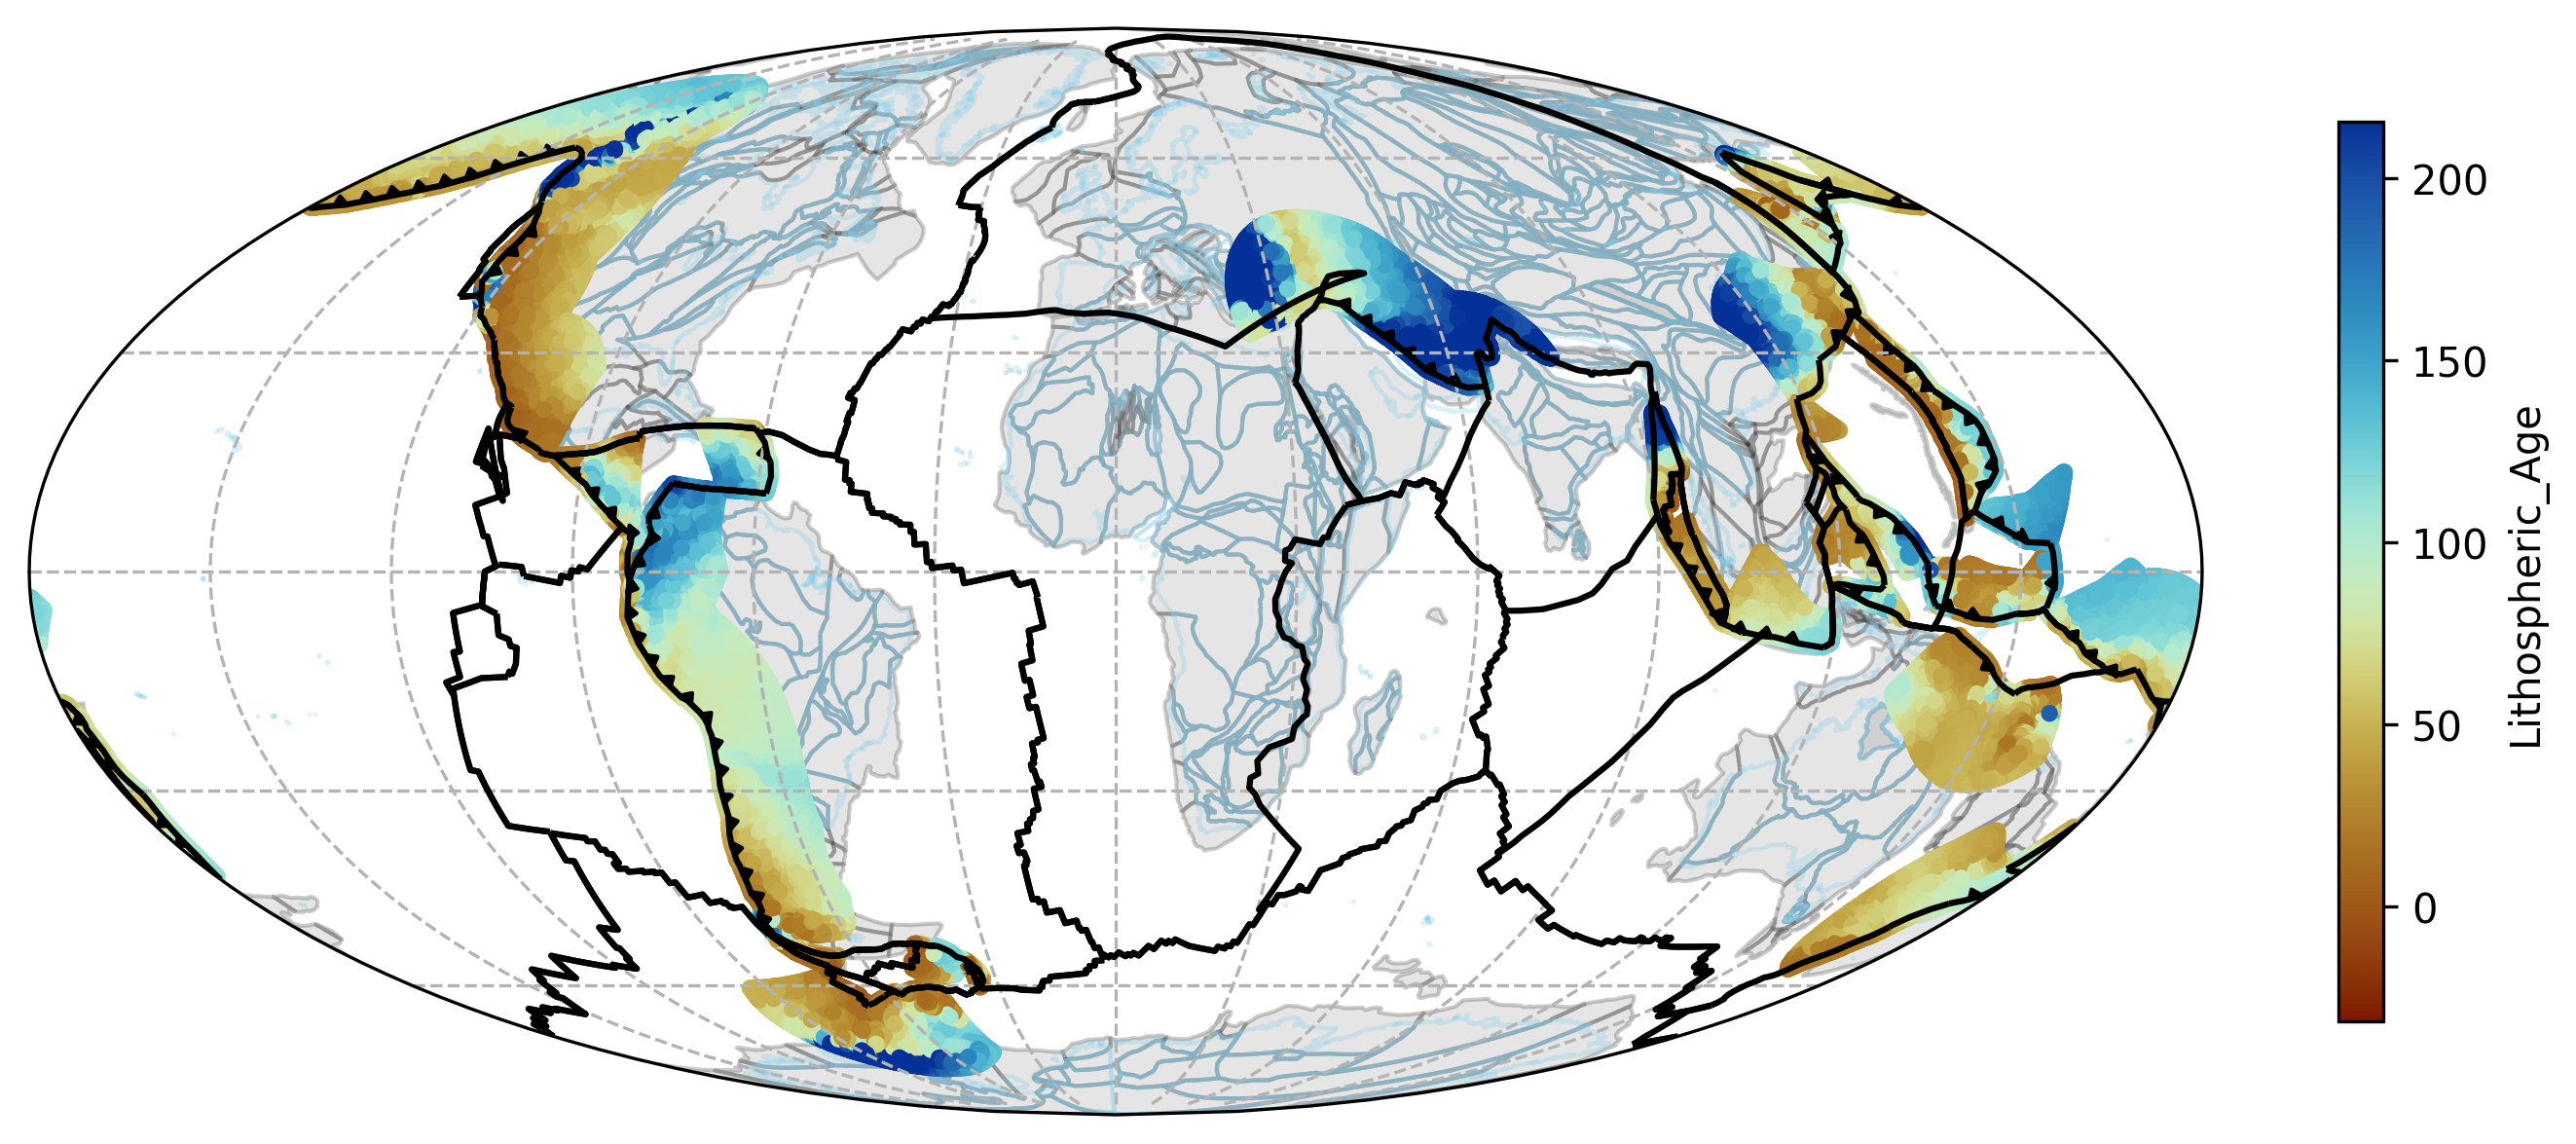

In [12]:
k=-1
columns=Data_gdf.columns
column=columns[k]

data = Data_gdf[column]
# Calculate mean and standard deviation
mean = data.mean()
std = data.std()

# Calculate vmin and vmax
vmin = mean - 2 * std
vmax = mean + 2 * std
kwargs={'vmin':vmin,'vmax':vmax,'cmap':cmc.roma,'label':column}



plotgdf(Data_gdf,gplot=gplot,time=reconstruction_time,column=column,cbar=True,mollweide=True,quick=False,**kwargs)

In [13]:
age_grid_file = find_filename_with_number(f"{DEFAULT_OUTPUT_NetCDF}/Interpolated_Seafloor/",reconstruction_time)

In [16]:
ds=xr.open_dataarray(age_grid_file)

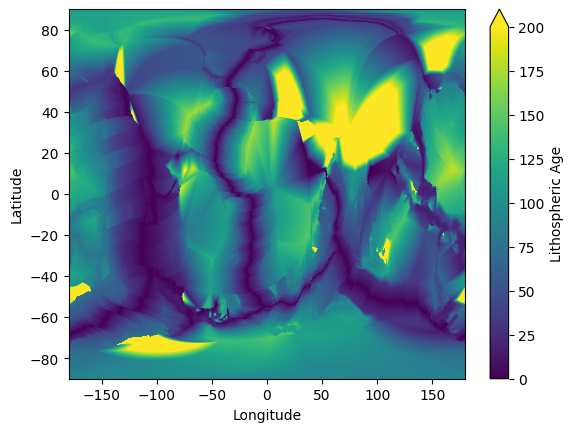

In [18]:
ds.plot(vmax=200)